In [0]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [0]:
import pandas as pd

In [0]:
import numpy as np

In [0]:
import matplotlib.pyplot as plt

In [0]:
import random

In [0]:
import time

#One Learner

In [0]:
def OneLearner(Data, Targets, Type, Interval, TestSamples):
  
  Model = 0

  if Type == "NB":
    Model = GaussianNB()
  if Type == "LG":
    Model = LogisticRegression(solver='lbfgs')
  
  TrainIndecis = []
  TestIndecis = []

  i = 1;

  while i < Data.shape[0]:

    if i%Interval == 0:
      for j in range(TestSamples):
        TestIndecis.append(i)
        i = i + 1
    else:
      TrainIndecis.append(i)
      i = i + 1
  
  Model.fit(Data[TrainIndecis], Targets[TrainIndecis])

  Acc = sum((Model.predict(Data[TestIndecis]) == Targets[TestIndecis])*1)/Targets[TestIndecis].shape[0]

  
  print("\n")
  print("Accuracy : ", Acc*100, "%")
  print("\n")



#DMW

## Base Learner

In [0]:
class Expert:

    def __init__(self, Type, Data, Targets, ExpertID, StartIndex):
        self.Data = Data
        self.Targets = Targets
        self.Indices = []
        if Type=="NB":
          self.Model = GaussianNB()
        if Type=="LG":
          self.Model = LogisticRegression(solver='lbfgs')
        
        TempTar = self.Targets[StartIndex:StartIndex + 10]
        if min(TempTar) == max(TempTar):
          if min(TempTar) == 0:
            TempTar[0] = 1
          else:
            TempTar[0] = 0
        self.Model.fit(self.Data[StartIndex:StartIndex + 10], TempTar)
        self.Weighte = 1
        self.ExpertID = ExpertID
        self.StartIndex = StartIndex
        print("The expert", ExpertID, "was created.")


    def Decay(self, Beta):
        self.Weighte = Beta*self.Weighte
        
        
        
    def Train(self, Current):
       
        if (Current - self.StartIndex) < 10 :
          TempTar = self.Targets[self.StartIndex : self.StartIndex + 10]
          if min(TempTar) == max(TempTar):
            if min(TempTar) == 0:
              TempTar[0] = 1
            else:
              TempTar[0] = 0
          self.Model.fit(self.Data[self.StartIndex : self.StartIndex + 10], TempTar)
        else :
          TempTar = self.Targets[self.Indices]
          if min(TempTar) == max(TempTar):
            if min(TempTar) == 0:
              TempTar[0] = 1
            else:
              TempTar[0] = 0
          self.Model.fit(self.Data[self.Indices], TempTar)
            
        
    def Classify(self, Example):

        return self.Model.predict(Example);

## Main Algorithm

In [0]:
class DWM:

    def __init__(self, Data, Target, Beta, Threshold, Period, Interval, TestSamples, AccType, BaseType):
        if Beta < 0 or Beta > 1:
            print("Invalid Beta.")
            return
        if Threshold <= 0:
            print("Invalid Threshold.")
            return
        if Period <= 0:
            print("Invalid Period.")
            return
            
        self.Data = Data
        self.Target = Target
        self.NumOfClasses = len(np.unique(Target))
        self.Beta = Beta
        self.Threshold = Threshold
        self.Period = Period
        self.Experts = []
        self.NumOfExamples = Target.shape[0]
        self.NumOfExperts = 0
        self.GlobalPrediction = []
        self.CurrentID = 1
        self.Acc = []
        self.Interval = Interval
        self.TestSamples = TestSamples
        self.AccType = AccType
        self.TrackExperts = []
        self.XAxis = []
        self.BaseType = BaseType
        self.OnePassTime = 0





    def Predict(self, i):

      LocalPrediction = [0 for p in range(self.NumOfClasses)]

      for j in range(self.NumOfExperts):

        Prediction_j = self.Experts[j].Classify(self.Data[i:i+1])[0]

        LocalPrediction[int(Prediction_j)] = LocalPrediction[int(Prediction_j)] + self.Experts[j].Weighte
      
      return LocalPrediction.index(max(LocalPrediction))




    def AccuracyAfter(self, Current, NumOfSamples):

        Sum = 0

        i= Current -  NumOfSamples
        
        while i < Current :

            if self.Target[i] == self.GlobalPrediction[i]:
                Sum = Sum + 1

            i = i + 1

        Acc = Sum/NumOfSamples

        self.Acc.append(Acc)

        return self.Acc


    def AccuracyBefore(self, Current, NumOfSamples):

        Sum = 0

        i = Current
        
        while i < Current + NumOfSamples:

            if self.Target[i] == self.Predict(i):
                Sum = Sum + 1

            i = i + 1
        
        Acc = Sum/NumOfSamples

        self.Acc.append(Acc)

        return self.Acc


    def Normalize(self):

        Max = -1;
        
        for j in range(self.NumOfExperts):

            if self.Experts[j].Weighte > Max:

                Max = self.Experts[j].Weighte

        for j in range(self.NumOfExperts):

            self.Experts[j].Decay(1.0/Max)

            

    def AddExpert(self, StartIndex, Type):

        self.NumOfExperts = self.NumOfExperts + 1

        _Expert = Expert(Type, self.Data, self.Target, self.CurrentID, StartIndex)

        self.CurrentID = self.CurrentID + 1

        self.Experts.append(_Expert)


    def Plot(self):

      plt.figure(figsize=(20, 4))
      
      plt.subplot(1, 2,1)
      
      plt.plot(self.XAxis, self.Acc)
      
      plt.title('Accuracy')
      
      plt.ylabel('Accuracy')
      
      plt.xlabel('Samples')
      
      plt.subplot(1, 2,2)
      
      plt.plot(self.XAxis, self.TrackExperts)
      
      plt.title('Number of Experts')
      
      plt.ylabel('Number of Experts')
      
      plt.xlabel('Samples')
      
      plt.show()


    def RemoveExperts(self):

        Flag = 1;

        while Flag == 1:

            Flag = 0

            for j in range(self.NumOfExperts):

                if self.Experts[j].Weighte < self.Threshold:

                    print("The expert", self.Experts[j].ExpertID ,"was removed with weight : ", self.Experts[j].Weighte)

                    self.NumOfExperts = self.NumOfExperts - 1

                    print(self.NumOfExperts, " Remaining experts.")

                    del self.Experts[j]

                    Flag = 1

                    break
    
    def Run_Mul(self, NumberOfRuns):
      
      StartTime = time.time()
      Models = []

      for i in range(NumberOfRuns):

        Ex =  DWM(Data=self.Data, Target=self.Target, Beta= self.Beta, Threshold = self.Threshold, Period= self.Period, Interval= self.Interval, TestSamples= self.TestSamples, AccType= self.AccType, BaseType=self.BaseType)

        Models.append(Ex)

        Ex.Run();

      for i in range(len(Models[0].Acc)):
        
        Sum1 = 0;
        Sum2 = 0;

        for j in range(NumberOfRuns):

          Sum1+= Models[j].Acc[i];

          Sum2+= Models[j].TrackExperts[i];
        
        self.Acc.append(Sum1/NumberOfRuns)

        self.TrackExperts.append(Sum2/NumberOfRuns)
      
      self.XAxis = Models[0].XAxis
      self.OnePassTime = (time.time() - StartTime)/NumberOfRuns
      self.Plot()
      
      print("\n")
      print("\n")
      print("\n")
      print("Mean Accuracy : ", (sum(self.Acc) / len(self.Acc))*100, "% ")
      print("\n")
      print("Mean Number Of Experts : ", (sum(self.TrackExperts) / len(self.TrackExperts)))
      print("\n")
      print("\n")
      print("\n")
      print("One Pass Time : ", (self.OnePassTime/60), "m")
      print("\n")
      print("\n")
      



    def Run(self):
      
      StartTime = time.time()
      # Add the first expert.
      #self.AddExpert(0, "NB")

      if self.BaseType == "Rand":
        if random.randint(0, 1) == 0:
          self.AddExpert(0, "NB")
        else:
          self.AddExpert(0, "LG")
      else:
        self.AddExpert(0, self.BaseType)
        

      
      # Loop over samples.
      for i in range(self.Data.shape[0]):

        
        if i > 0:
          if i%self.Interval == 0:
            print(i)
            self.TrackExperts.append(self.NumOfExperts)
            self.XAxis.append(i + self.TestSamples)
            if self.AccType == "AfterTrain":
              self.AccuracyAfter(i, self.TestSamples)
            if self.AccType == "BeforeTrain":
              self.AccuracyBefore(i, self.TestSamples)
         
     
        # Init local and global predictions.
        LocalPrediction = [0 for p in range(self.NumOfClasses)]

        GlobalPrediction = -1;


        # Loop over experts.
        for j in range(self.NumOfExperts):
          
          # Get prediction of sample i from expert j 
          Prediction_j = self.Experts[j].Classify(self.Data[i:i+1])[0]


          # Update weighte of expert j in case of wron prediction
          if Prediction_j != self.Target[i]:
            if i % self.Period == 0:
              self.Experts[j].Decay(self.Beta)
           
          # Update local prediction based on expert j
          LocalPrediction[int(Prediction_j)] = LocalPrediction[int(Prediction_j)] + self.Experts[j].Weighte


        # Get global prediction for sampel i
        GlobalPrediction_i = LocalPrediction.index(max(LocalPrediction))

        self.GlobalPrediction.append(GlobalPrediction_i)


        # Normalize, add and remove experts 
        if i % self.Period == 0:

          
          
          self.Normalize()
          
          self.RemoveExperts()
              
          if GlobalPrediction_i != self.Target[i]:
            if self.BaseType == "Rand":
              if random.randint(0, 1) == 0:
                self.AddExpert(i, "NB")
              else:
                self.AddExpert(i, "LG")
            else:
              self.AddExpert(i, self.BaseType)

        # Increment and train experts
        for j in range(self.NumOfExperts):
          self.Experts[j].Indices.append(i);
          
          self.Experts[j].Train(i)
      
      self.OnePassTime = time.time() - StartTime
      self.Plot()
      
      print("\n")
      print("\n")
      print("\n")
      print("Mean Accuracy : ", (sum(self.Acc) / len(self.Acc))*100, "% ")
      print("\n")
      print("Mean Number Of Experts : ", (sum(self.TrackExperts) / len(self.TrackExperts)))
      print("\n")
      print("\n")
      print("\n")
      print("One Pass Time : ", (self.OnePassTime/60), "m")
      print("\n")
      print("\n")
                

#Experiments

###STAGGER Concept

### Generate STAGGER Concept

In [0]:
# Based on the STAGGER concept description

StreamSize = 120

Color = ["green", "blue", "red"]

Shape = ["triangle", "circle", "rectangl"]

Size = ["small", "medium", "large"]



# "green", "blue", "red" "triangle", "circle", "rectangl" "small", "medium", "large"
Features = np.zeros([StreamSize, 9])



for i in range(StreamSize):

  R1 = random.randint(0, 2)

  R2 = random.randint(0, 2) 

  R3 = random.randint(0, 2)

  Features[i, 0 + R1] = 1
  Features[i, 3 + R2] = 1
  Features[i, 6 + R3] = 1

  
Labels = np.ndarray([StreamSize, 1])

Third = int(StreamSize/3)

Labels[:Third, 0] = (Features[:Third, 2] == 1) * (Features[:Third, 6]  == 1 )

Labels[Third:2*Third, 0] = (Features[Third:2*Third, 0] == 1) + (Features[Third:2*Third, 4]  == 1)

Labels[2*Third:StreamSize, 0] = (Features[2*Third:StreamSize, 7] == 1)

Labels = Labels[:,0]

### One Learner

#### NB

In [11]:
OneLearner(Features, Labels, "NB", 8, 2)



Accuracy :  60.71428571428571 %




#### LG

In [12]:
OneLearner(Features, Labels, "LG", 8, 2)



Accuracy :  67.85714285714286 %




### NB Base Learners

The expert 1 was created.
10
20
30
40
The expert 2 was created.
50
The expert 1 was removed with weight :  0.0078125
1  Remaining experts.
60
70
80
The expert 3 was created.
90
The expert 2 was removed with weight :  0.0078125
1  Remaining experts.
100
110


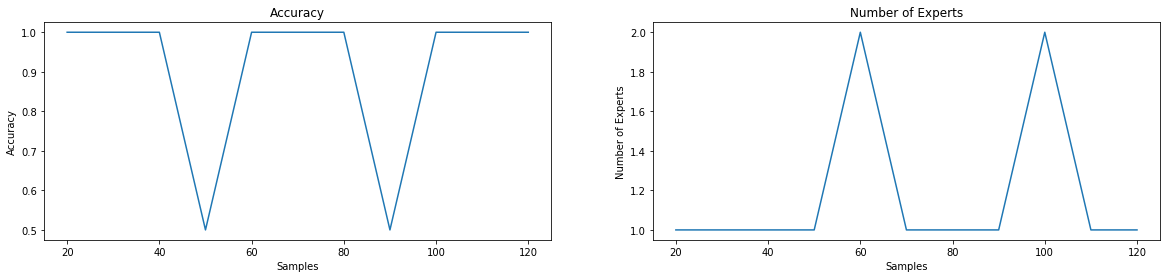







Mean Accuracy :  90.9090909090909 % 


Mean Number Of Experts :  1.1818181818181819






One Pass Time :  0.0017098506291707356 m




The expert 1 was created.
10
20
30
40
The expert 2 was created.
50
The expert 1 was removed with weight :  0.0078125
1  Remaining experts.
60
70
80
The expert 3 was created.
90
The expert 2 was removed with weight :  0.0078125
1  Remaining experts.
100
110


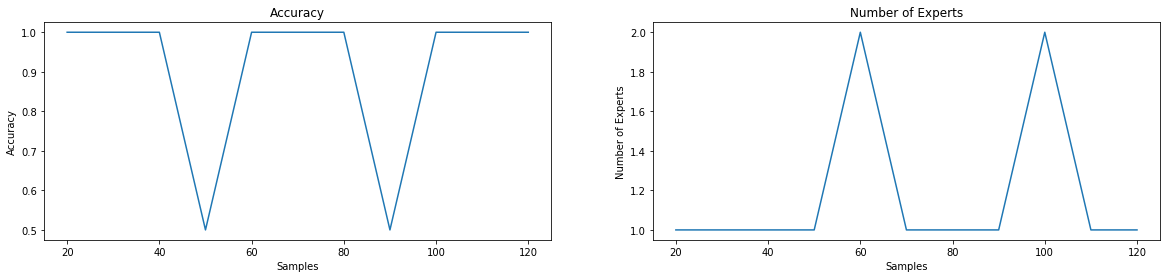







Mean Accuracy :  90.9090909090909 % 


Mean Number Of Experts :  1.1818181818181819






One Pass Time :  0.002207084496815999 m




The expert 1 was created.
10
20
30
40
The expert 2 was created.
50
The expert 1 was removed with weight :  0.0078125
1  Remaining experts.
60
70
80
The expert 3 was created.
90
The expert 2 was removed with weight :  0.0078125
1  Remaining experts.
100
110


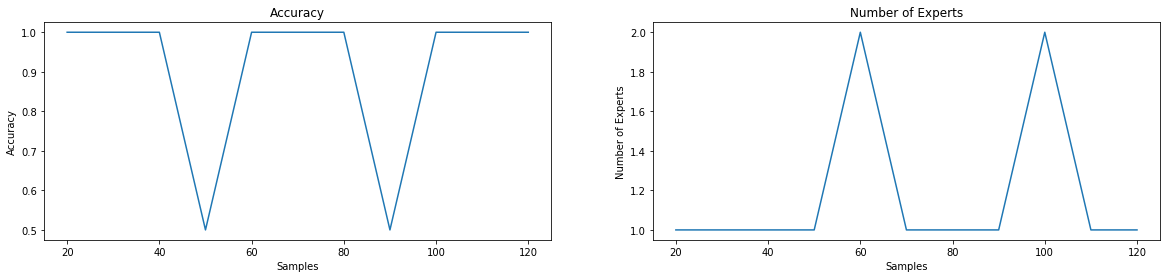







Mean Accuracy :  90.9090909090909 % 


Mean Number Of Experts :  1.1818181818181819






One Pass Time :  0.0022316614786783854 m






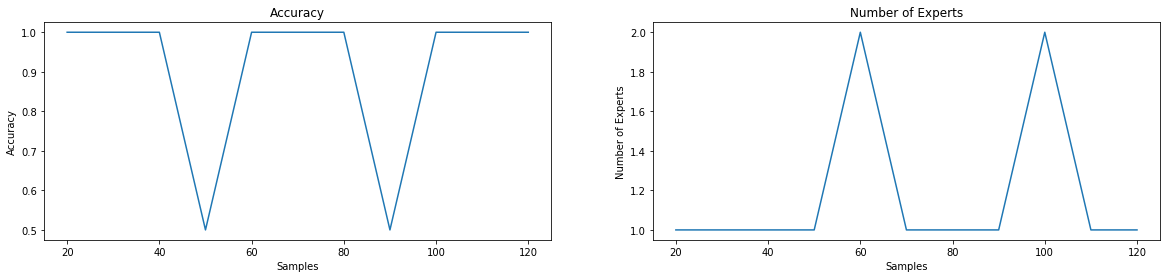







Mean Accuracy :  90.9090909090909 % 


Mean Number Of Experts :  1.1818181818181819






One Pass Time :  0.007230614291297065 m






In [13]:
Ex = DWM(Data=Features, Target=Labels, Beta=0.5, Threshold = 0.01, Period= 1, Interval=10, TestSamples= 10, AccType="BeforeTrain", BaseType="NB")

Ex.Run_Mul(3)

The expert 1 was created.
10
20
30
40
The expert 2 was created.
50
60
70
80
The expert 1 was removed with weight :  0.0078125
1  Remaining experts.
The expert 3 was created.
90
100
The expert 2 was removed with weight :  0.0078125
1  Remaining experts.
110


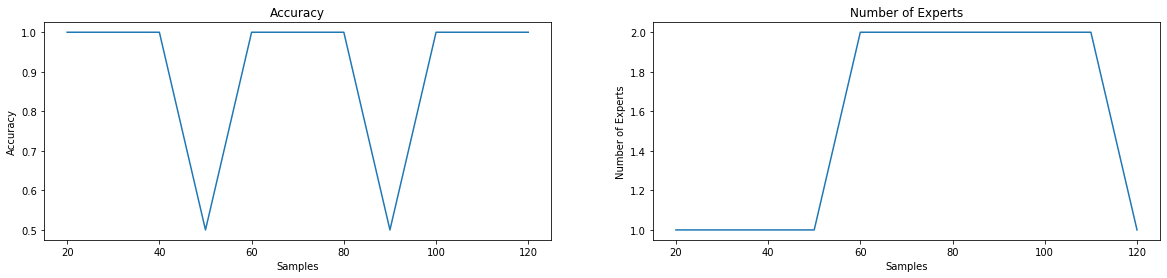







Mean Accuracy :  90.9090909090909 % 


Mean Number Of Experts :  1.5454545454545454






One Pass Time :  0.002734688917795817 m




The expert 1 was created.
10
20
30
40
The expert 2 was created.
50
60
70
80
The expert 1 was removed with weight :  0.0078125
1  Remaining experts.
The expert 3 was created.
90
100
The expert 2 was removed with weight :  0.0078125
1  Remaining experts.
110


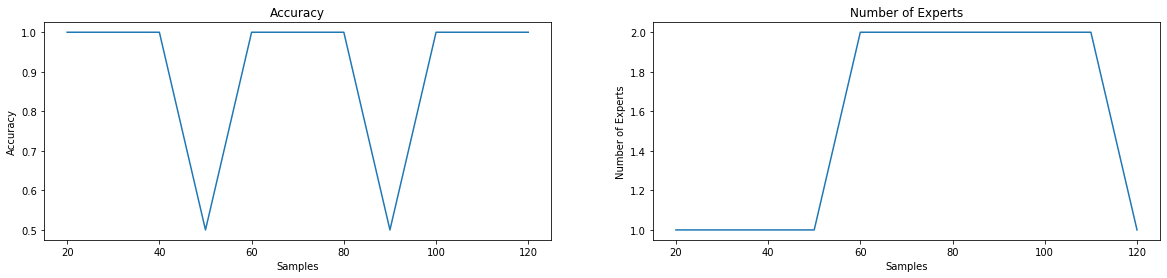







Mean Accuracy :  90.9090909090909 % 


Mean Number Of Experts :  1.5454545454545454






One Pass Time :  0.002446635564168294 m




The expert 1 was created.
10
20
30
40
The expert 2 was created.
50
60
70
80
The expert 1 was removed with weight :  0.0078125
1  Remaining experts.
The expert 3 was created.
90
100
The expert 2 was removed with weight :  0.0078125
1  Remaining experts.
110


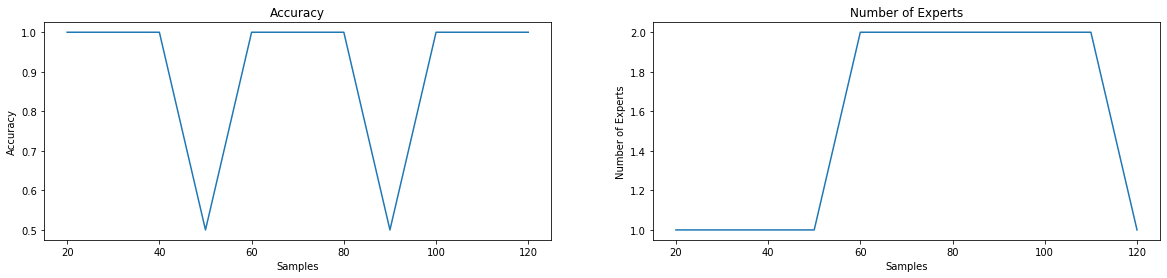







Mean Accuracy :  90.9090909090909 % 


Mean Number Of Experts :  1.5454545454545454






One Pass Time :  0.002572067578633626 m






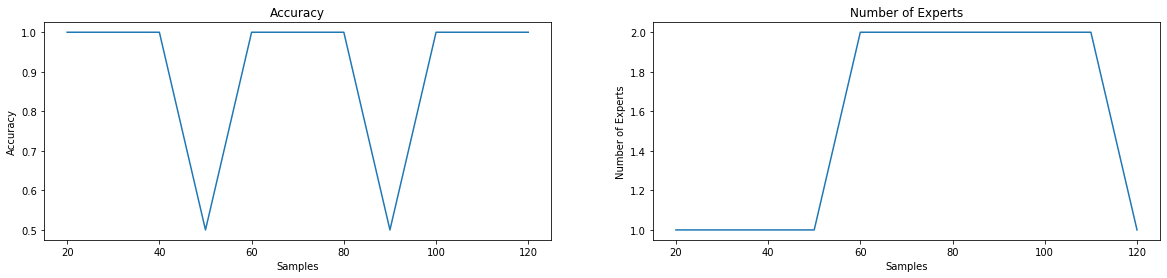







Mean Accuracy :  90.9090909090909 % 


Mean Number Of Experts :  1.5454545454545454






One Pass Time :  0.00739085144466824 m






In [14]:
Ex = DWM(Data=Features, Target=Labels, Beta=0.5, Threshold = 0.01, Period= 2, Interval=10, TestSamples= 10, AccType="BeforeTrain", BaseType="NB")

Ex.Run_Mul(3)

The expert 1 was created.
10
20
30
40
The expert 2 was created.
50
60
70
80
The expert 3 was created.
90
The expert 1 was removed with weight :  0.0078125
2  Remaining experts.
100
110


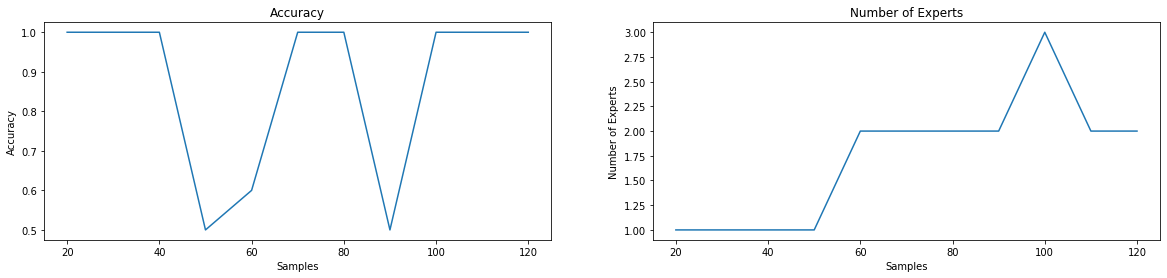







Mean Accuracy :  87.27272727272727 % 


Mean Number Of Experts :  1.7272727272727273






One Pass Time :  0.0026084224383036295 m




The expert 1 was created.
10
20
30
40
The expert 2 was created.
50
60
70
80
The expert 3 was created.
90
The expert 1 was removed with weight :  0.0078125
2  Remaining experts.
100
110


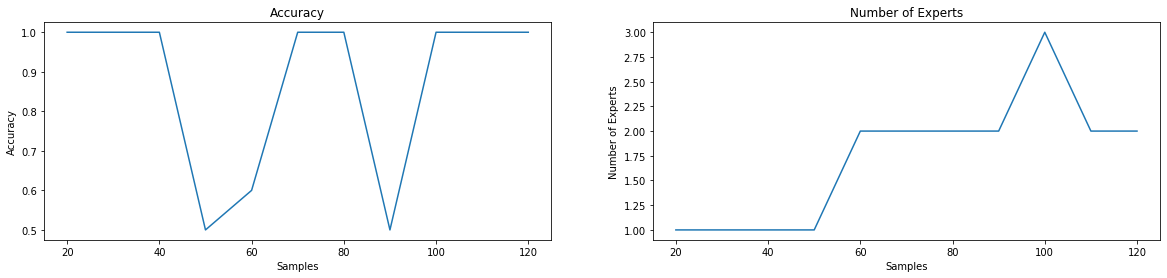







Mean Accuracy :  87.27272727272727 % 


Mean Number Of Experts :  1.7272727272727273






One Pass Time :  0.002736655871073405 m




The expert 1 was created.
10
20
30
40
The expert 2 was created.
50
60
70
80
The expert 3 was created.
90
The expert 1 was removed with weight :  0.0078125
2  Remaining experts.
100
110


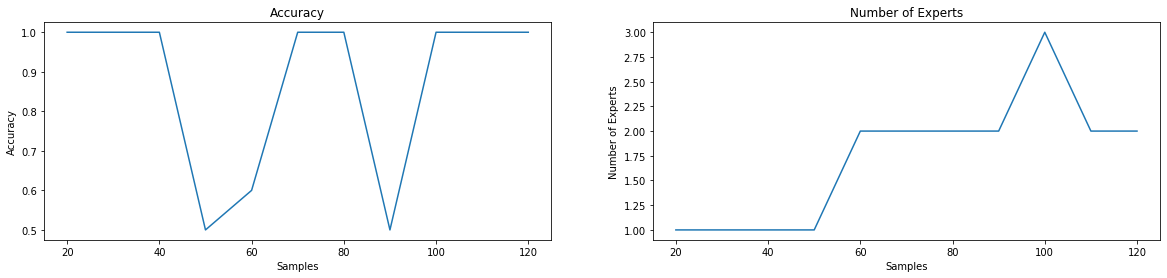







Mean Accuracy :  87.27272727272727 % 


Mean Number Of Experts :  1.7272727272727273






One Pass Time :  0.002899503707885742 m






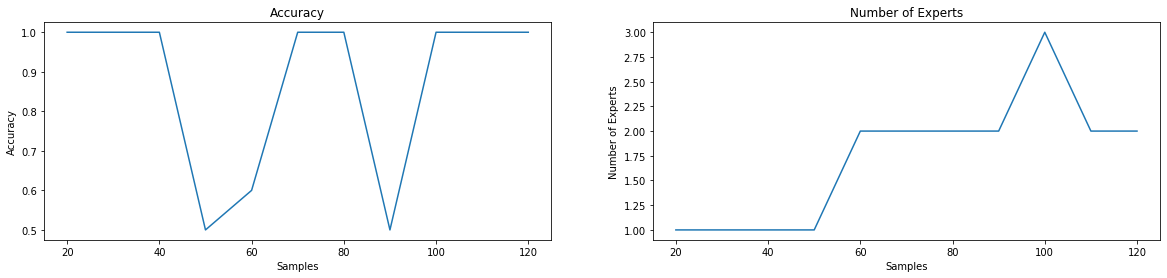







Mean Accuracy :  87.27272727272727 % 


Mean Number Of Experts :  1.7272727272727273






One Pass Time :  0.00833410422007243 m






In [15]:
Ex = DWM(Data=Features, Target=Labels, Beta=0.5, Threshold = 0.01, Period= 4, Interval=10, TestSamples= 10, AccType="BeforeTrain", BaseType="NB")

Ex.Run_Mul(3)

### LG Base Learners

The expert 1 was created.
10
The expert 2 was created.
20
The expert 3 was created.
30
The expert 4 was created.
40
The expert 5 was created.
The expert 6 was created.
The expert 2 was removed with weight :  0.0078125
5  Remaining experts.
The expert 3 was removed with weight :  0.0078125
4  Remaining experts.
50
The expert 1 was removed with weight :  0.0078125
3  Remaining experts.
60
70
80
The expert 7 was created.
The expert 4 was removed with weight :  0.0078125
3  Remaining experts.
90
The expert 6 was removed with weight :  0.0078125
2  Remaining experts.
The expert 5 was removed with weight :  0.0078125
1  Remaining experts.
100
110


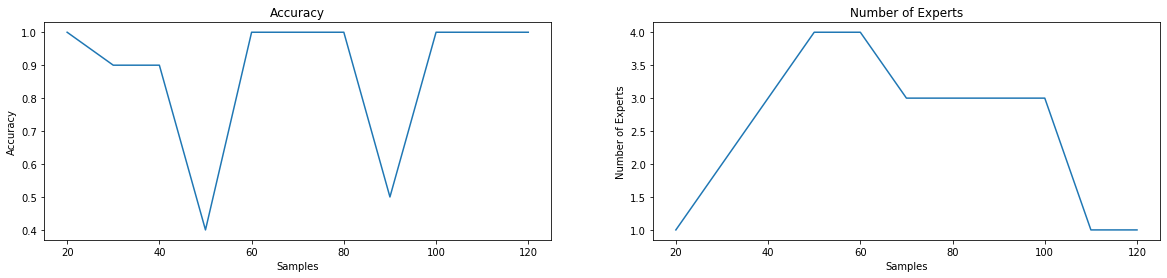







Mean Accuracy :  88.18181818181817 % 


Mean Number Of Experts :  2.5454545454545454






One Pass Time :  0.010929735501607259 m




The expert 1 was created.
10
The expert 2 was created.
20
The expert 3 was created.
30
The expert 4 was created.
40
The expert 5 was created.
The expert 6 was created.
The expert 2 was removed with weight :  0.0078125
5  Remaining experts.
The expert 3 was removed with weight :  0.0078125
4  Remaining experts.
50
The expert 1 was removed with weight :  0.0078125
3  Remaining experts.
60
70
80
The expert 7 was created.
The expert 4 was removed with weight :  0.0078125
3  Remaining experts.
90
The expert 6 was removed with weight :  0.0078125
2  Remaining experts.
The expert 5 was removed with weight :  0.0078125
1  Remaining experts.
100
110


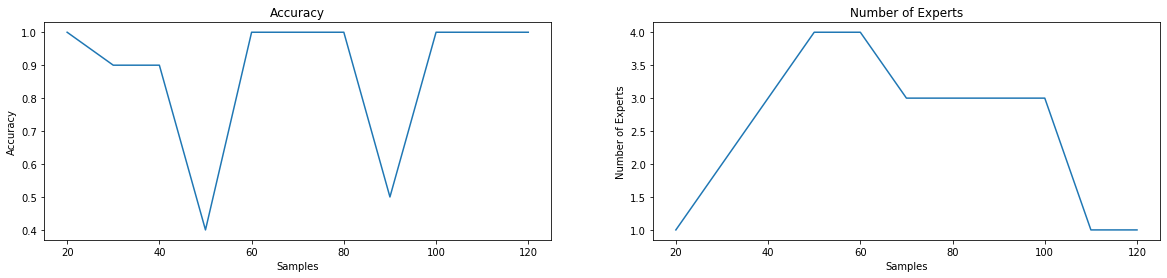







Mean Accuracy :  88.18181818181817 % 


Mean Number Of Experts :  2.5454545454545454






One Pass Time :  0.011082963148752848 m




The expert 1 was created.
10
The expert 2 was created.
20
The expert 3 was created.
30
The expert 4 was created.
40
The expert 5 was created.
The expert 6 was created.
The expert 2 was removed with weight :  0.0078125
5  Remaining experts.
The expert 3 was removed with weight :  0.0078125
4  Remaining experts.
50
The expert 1 was removed with weight :  0.0078125
3  Remaining experts.
60
70
80
The expert 7 was created.
The expert 4 was removed with weight :  0.0078125
3  Remaining experts.
90
The expert 6 was removed with weight :  0.0078125
2  Remaining experts.
The expert 5 was removed with weight :  0.0078125
1  Remaining experts.
100
110


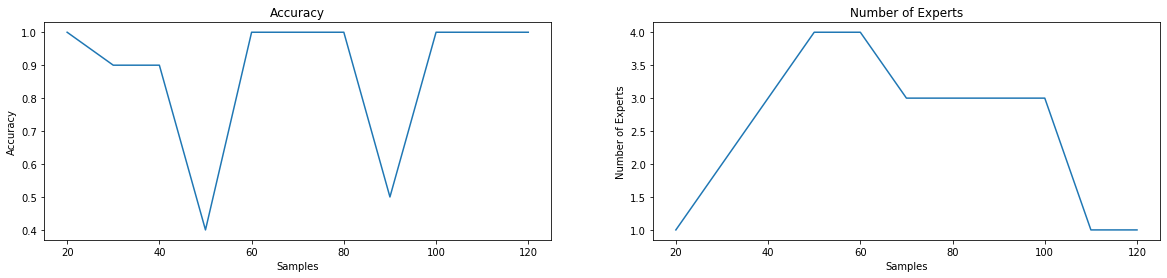







Mean Accuracy :  88.18181818181817 % 


Mean Number Of Experts :  2.5454545454545454






One Pass Time :  0.01238706111907959 m






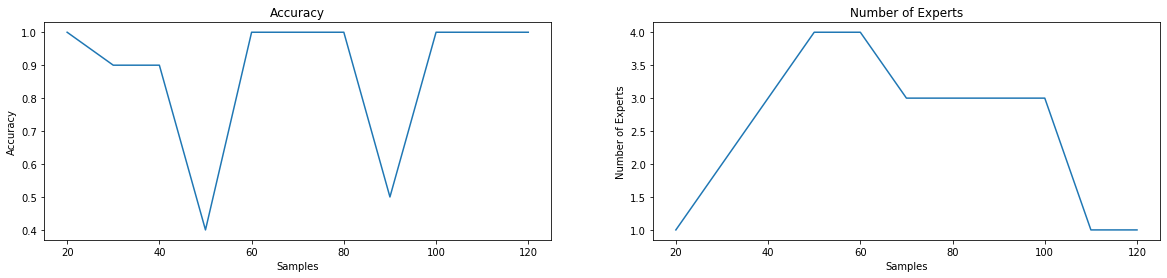







Mean Accuracy :  88.18181818181817 % 


Mean Number Of Experts :  2.5454545454545454






One Pass Time :  0.016505670547485352 m






In [16]:
Ex = DWM(Data=Features, Target=Labels, Beta=0.5, Threshold = 0.01, Period= 1, Interval=10, TestSamples= 10, AccType="BeforeTrain", BaseType="LG")

Ex.Run_Mul(3)

The expert 1 was created.
10
The expert 2 was created.
20
The expert 3 was created.
30
40
The expert 4 was created.
The expert 5 was created.
50
60
The expert 1 was removed with weight :  0.0078125
4  Remaining experts.
The expert 2 was removed with weight :  0.0078125
3  Remaining experts.
70
80
The expert 6 was created.
The expert 3 was removed with weight :  0.0078125
3  Remaining experts.
90
The expert 5 was removed with weight :  0.0078125
2  Remaining experts.
100
The expert 4 was removed with weight :  0.0078125
1  Remaining experts.
110


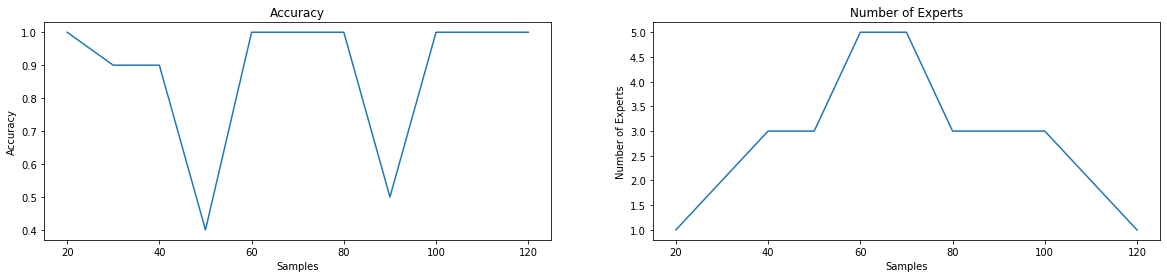







Mean Accuracy :  88.18181818181817 % 


Mean Number Of Experts :  2.8181818181818183






One Pass Time :  0.012190743287404378 m




The expert 1 was created.
10
The expert 2 was created.
20
The expert 3 was created.
30
40
The expert 4 was created.
The expert 5 was created.
50
60
The expert 1 was removed with weight :  0.0078125
4  Remaining experts.
The expert 2 was removed with weight :  0.0078125
3  Remaining experts.
70
80
The expert 6 was created.
The expert 3 was removed with weight :  0.0078125
3  Remaining experts.
90
The expert 5 was removed with weight :  0.0078125
2  Remaining experts.
100
The expert 4 was removed with weight :  0.0078125
1  Remaining experts.
110


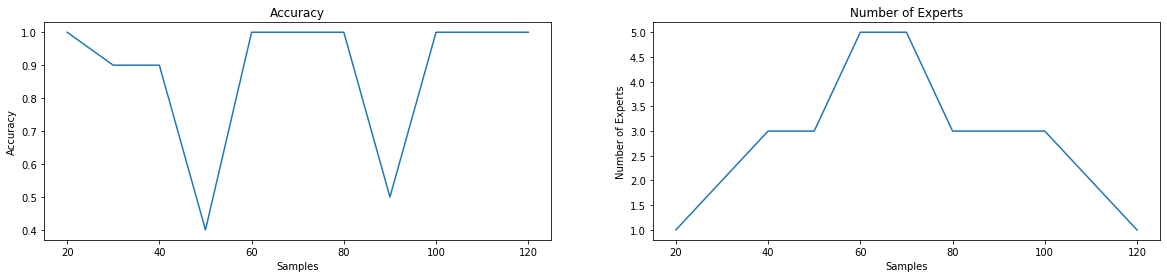







Mean Accuracy :  88.18181818181817 % 


Mean Number Of Experts :  2.8181818181818183






One Pass Time :  0.012079509099324544 m




The expert 1 was created.
10
The expert 2 was created.
20
The expert 3 was created.
30
40
The expert 4 was created.
The expert 5 was created.
50
60
The expert 1 was removed with weight :  0.0078125
4  Remaining experts.
The expert 2 was removed with weight :  0.0078125
3  Remaining experts.
70
80
The expert 6 was created.
The expert 3 was removed with weight :  0.0078125
3  Remaining experts.
90
The expert 5 was removed with weight :  0.0078125
2  Remaining experts.
100
The expert 4 was removed with weight :  0.0078125
1  Remaining experts.
110


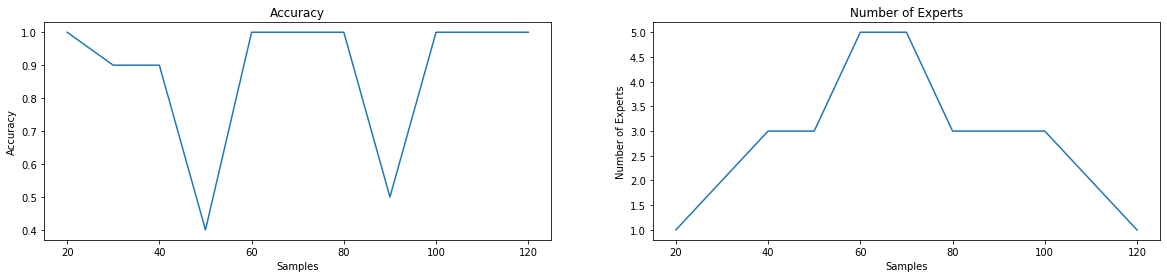







Mean Accuracy :  88.18181818181817 % 


Mean Number Of Experts :  2.8181818181818183






One Pass Time :  0.01176542043685913 m






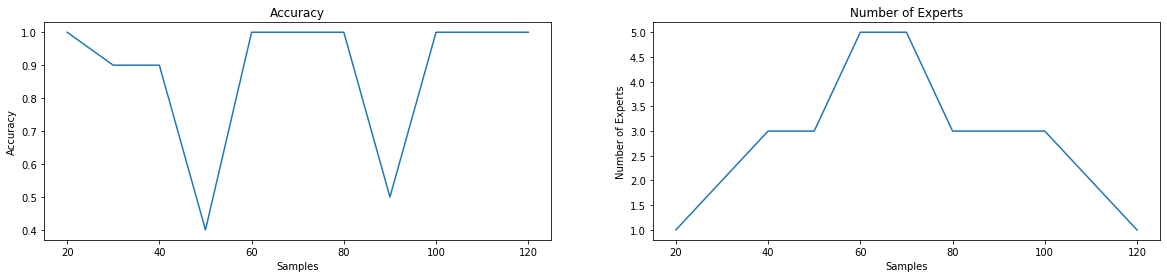







Mean Accuracy :  88.18181818181817 % 


Mean Number Of Experts :  2.8181818181818183






One Pass Time :  0.016780070463816323 m






In [17]:
Ex = DWM(Data=Features, Target=Labels, Beta=0.5, Threshold = 0.01, Period= 2, Interval=10, TestSamples= 10, AccType="BeforeTrain", BaseType="LG")

Ex.Run_Mul(3)

The expert 1 was created.
10
20
30
40
The expert 2 was created.
50
60
The expert 1 was removed with weight :  0.0078125
1  Remaining experts.
70
80
The expert 3 was created.
90
100
110


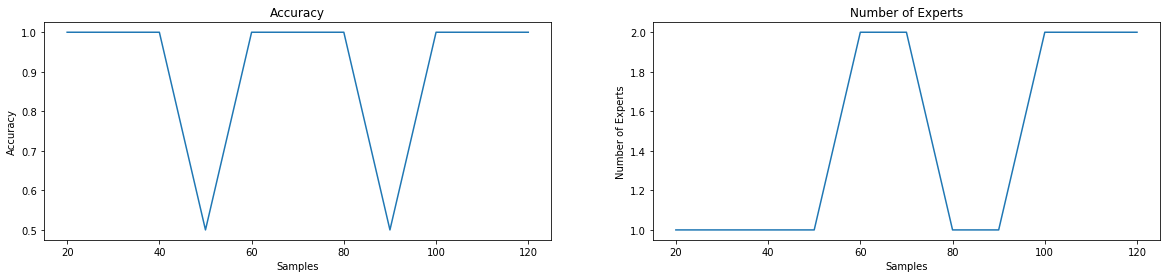







Mean Accuracy :  90.9090909090909 % 


Mean Number Of Experts :  1.4545454545454546






One Pass Time :  0.006684426466623942 m




The expert 1 was created.
10
20
30
40
The expert 2 was created.
50
60
The expert 1 was removed with weight :  0.0078125
1  Remaining experts.
70
80
The expert 3 was created.
90
100
110


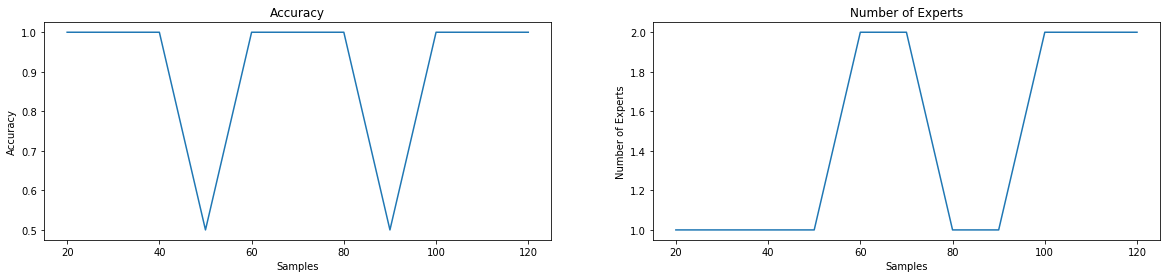







Mean Accuracy :  90.9090909090909 % 


Mean Number Of Experts :  1.4545454545454546






One Pass Time :  0.006540755430857341 m




The expert 1 was created.
10
20
30
40
The expert 2 was created.
50
60
The expert 1 was removed with weight :  0.0078125
1  Remaining experts.
70
80
The expert 3 was created.
90
100
110


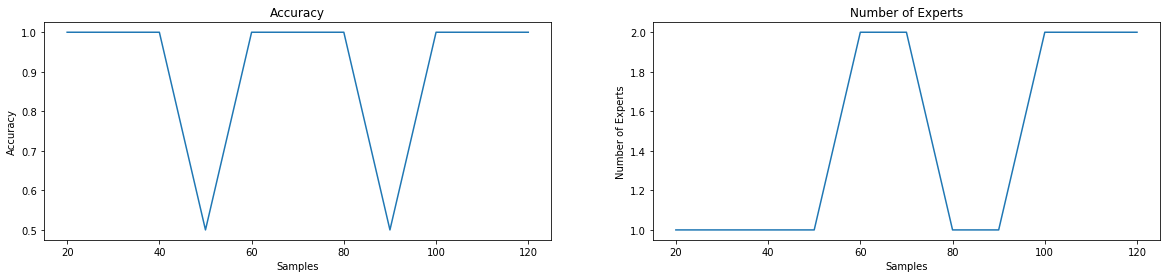







Mean Accuracy :  90.9090909090909 % 


Mean Number Of Experts :  1.4545454545454546






One Pass Time :  0.007060742378234864 m






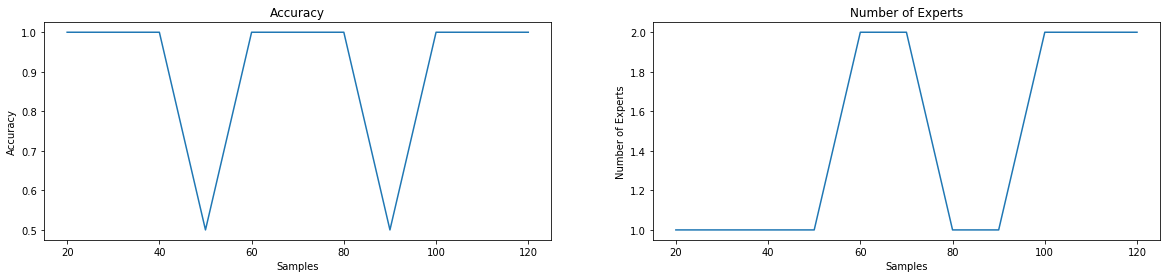







Mean Accuracy :  90.9090909090909 % 


Mean Number Of Experts :  1.4545454545454546






One Pass Time :  0.011408543586730957 m






In [18]:
Ex = DWM(Data=Features, Target=Labels, Beta=0.5, Threshold = 0.01, Period= 4, Interval=10, TestSamples= 10, AccType="BeforeTrain", BaseType="LG")

Ex.Run_Mul(3)

### LG and NB Base Learners

The expert 1 was created.
10
20
30
40
The expert 2 was created.
50
The expert 1 was removed with weight :  0.0078125
1  Remaining experts.
60
70
80
The expert 3 was created.
90
The expert 2 was removed with weight :  0.0078125
1  Remaining experts.
100
110


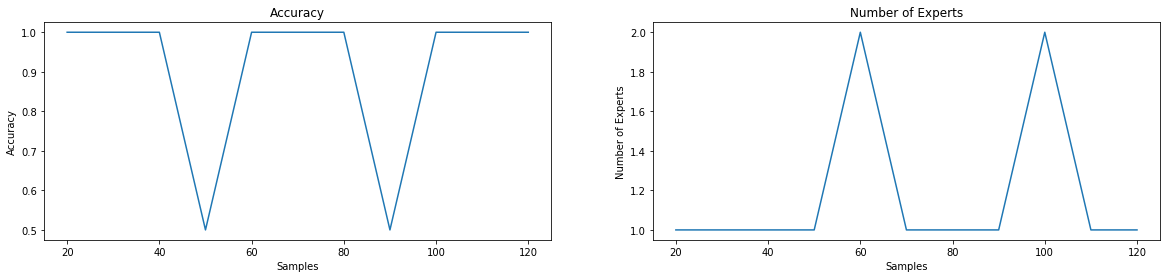







Mean Accuracy :  90.9090909090909 % 


Mean Number Of Experts :  1.1818181818181819






One Pass Time :  0.0032907605171203615 m




The expert 1 was created.
10
20
30
40
The expert 2 was created.
50
The expert 1 was removed with weight :  0.0078125
1  Remaining experts.
60
70
80
The expert 3 was created.
90
The expert 2 was removed with weight :  0.0078125
1  Remaining experts.
100
110


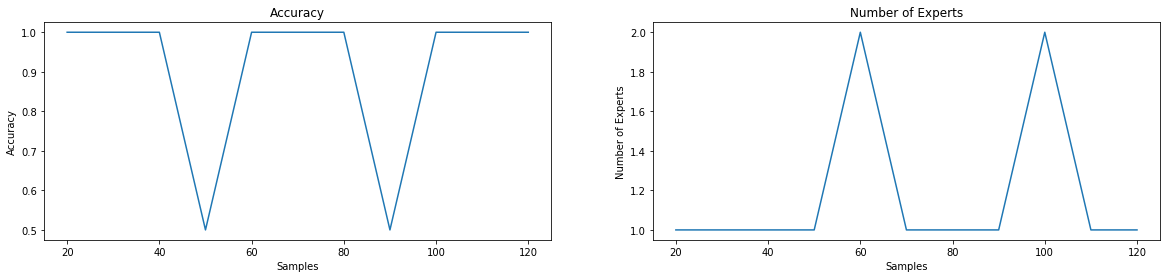







Mean Accuracy :  90.9090909090909 % 


Mean Number Of Experts :  1.1818181818181819






One Pass Time :  0.00453956127166748 m




The expert 1 was created.
10
20
30
40
The expert 2 was created.
50
The expert 1 was removed with weight :  0.0078125
1  Remaining experts.
60
70
80
The expert 3 was created.
90
The expert 2 was removed with weight :  0.0078125
1  Remaining experts.
100
110


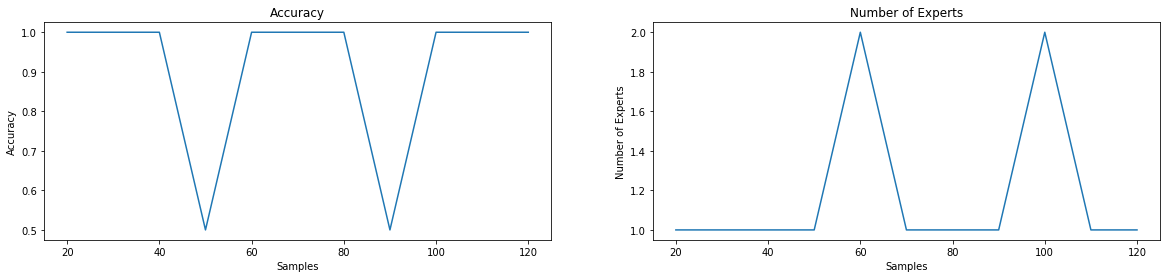







Mean Accuracy :  90.9090909090909 % 


Mean Number Of Experts :  1.1818181818181819






One Pass Time :  0.003209853172302246 m






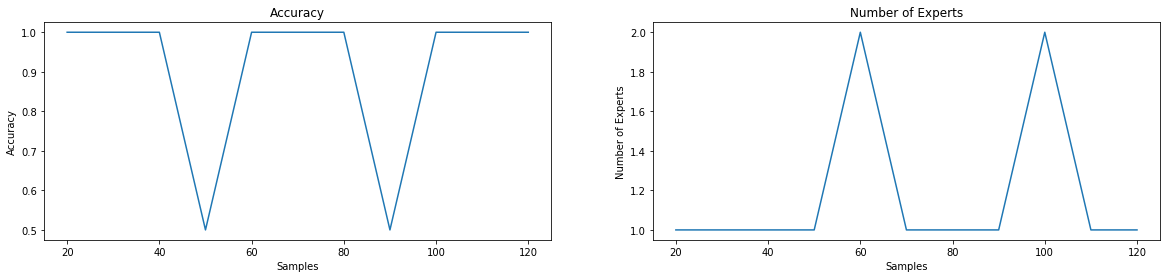







Mean Accuracy :  90.9090909090909 % 


Mean Number Of Experts :  1.1818181818181819






One Pass Time :  0.008797564771440293 m






In [19]:
Ex = DWM(Data=Features, Target=Labels, Beta=0.5, Threshold = 0.01, Period= 1, Interval=10, TestSamples= 10, AccType="BeforeTrain", BaseType="Rand")

Ex.Run_Mul(3)

The expert 1 was created.
10
20
30
40
The expert 2 was created.
50
60
70
80
The expert 1 was removed with weight :  0.0078125
1  Remaining experts.
The expert 3 was created.
90
100
The expert 2 was removed with weight :  0.0078125
1  Remaining experts.
110


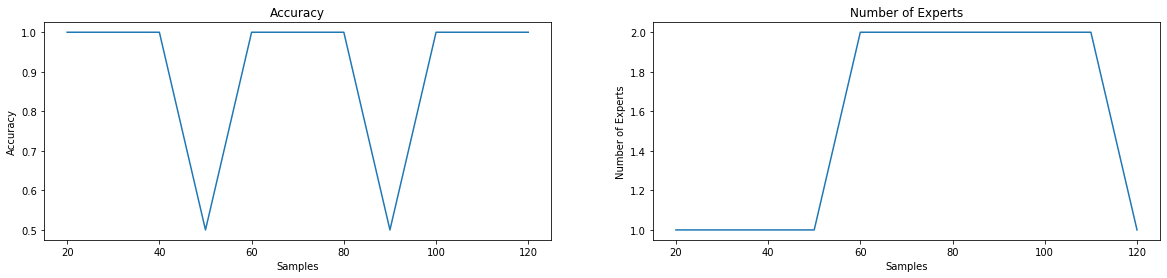







Mean Accuracy :  90.9090909090909 % 


Mean Number Of Experts :  1.5454545454545454






One Pass Time :  0.0026894807815551758 m




The expert 1 was created.
10
The expert 2 was created.
20
The expert 3 was created.
30
40
The expert 4 was created.
The expert 5 was created.
50
60
The expert 1 was removed with weight :  0.0078125
4  Remaining experts.
70
80
The expert 6 was created.
The expert 7 was created.
The expert 3 was removed with weight :  0.0078125
5  Remaining experts.
90
The expert 2 was removed with weight :  0.0078125
4  Remaining experts.
100
The expert 4 was removed with weight :  0.0078125
3  Remaining experts.
The expert 5 was removed with weight :  0.0078125
2  Remaining experts.
110


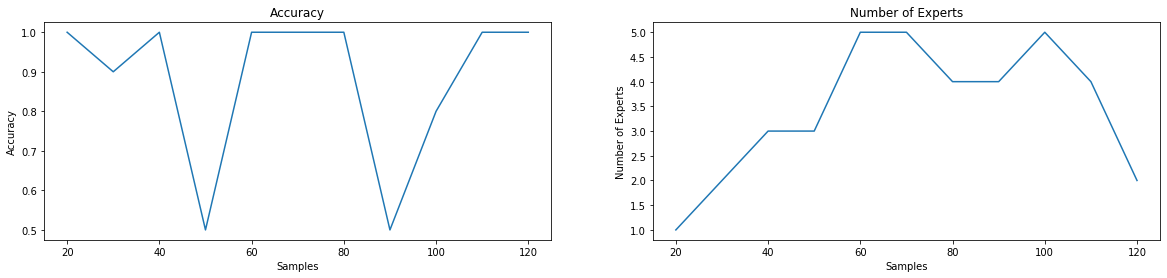







Mean Accuracy :  88.18181818181817 % 


Mean Number Of Experts :  3.4545454545454546






One Pass Time :  0.011566619078318277 m




The expert 1 was created.
10
The expert 2 was created.
20
The expert 3 was created.
30
40
The expert 4 was created.
The expert 5 was created.
50
60
The expert 1 was removed with weight :  0.0078125
4  Remaining experts.
70
80
The expert 6 was created.
The expert 3 was removed with weight :  0.0078125
4  Remaining experts.
90
The expert 2 was removed with weight :  0.0078125
3  Remaining experts.
The expert 5 was removed with weight :  0.0078125
2  Remaining experts.
100
The expert 4 was removed with weight :  0.0078125
1  Remaining experts.
110


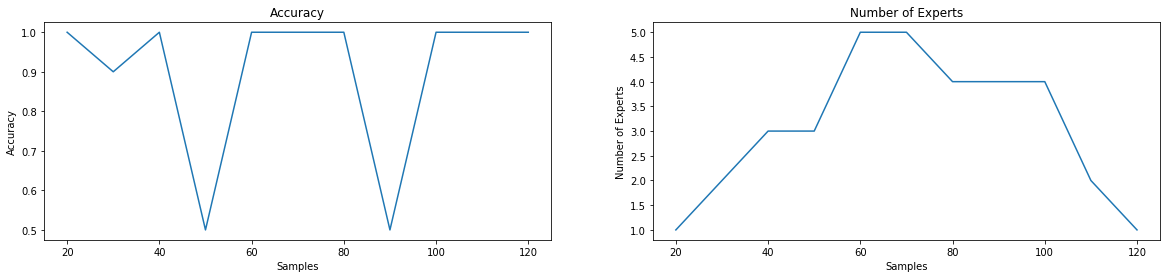







Mean Accuracy :  90.0 % 


Mean Number Of Experts :  3.090909090909091






One Pass Time :  0.011638967196146648 m






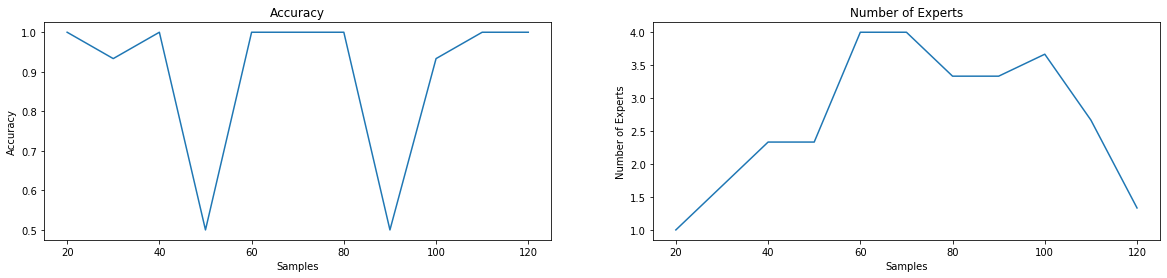







Mean Accuracy :  89.6969696969697 % 


Mean Number Of Experts :  2.6969696969696972






One Pass Time :  0.01352475086847941 m






In [20]:
Ex = DWM(Data=Features, Target=Labels, Beta=0.5, Threshold = 0.01, Period= 2, Interval=10, TestSamples= 10, AccType="BeforeTrain", BaseType="Rand")

Ex.Run_Mul(3)

The expert 1 was created.
10
20
30
40
The expert 2 was created.
50
60
The expert 1 was removed with weight :  0.0078125
1  Remaining experts.
70
80
The expert 3 was created.
90
100
110


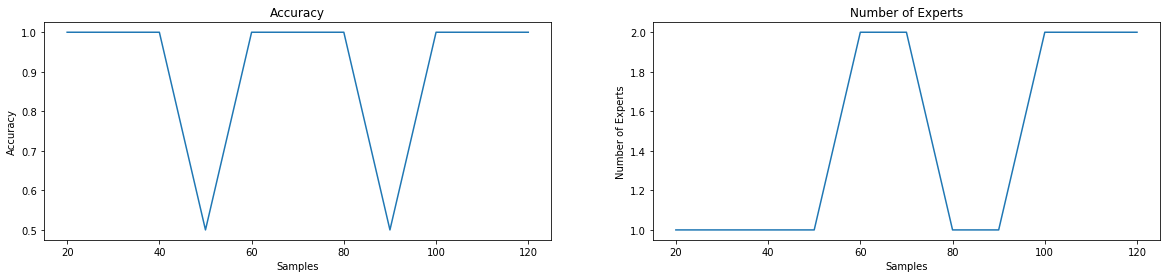







Mean Accuracy :  90.9090909090909 % 


Mean Number Of Experts :  1.4545454545454546






One Pass Time :  0.004216404755910238 m




The expert 1 was created.
10
20
30
40
The expert 2 was created.
50
60
The expert 1 was removed with weight :  0.0078125
1  Remaining experts.
70
80
The expert 3 was created.
90
100
110


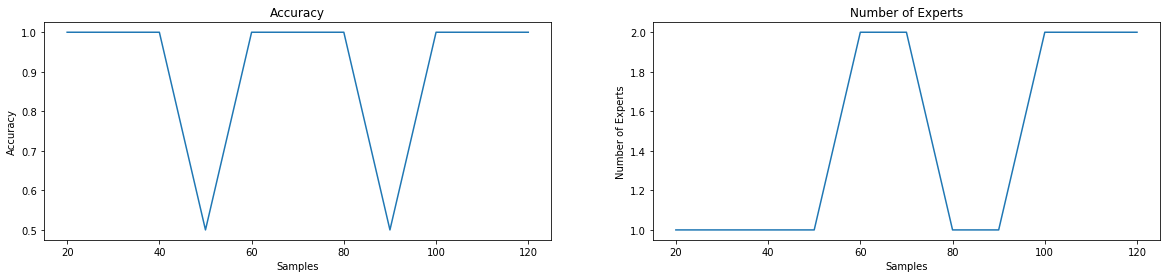







Mean Accuracy :  90.9090909090909 % 


Mean Number Of Experts :  1.4545454545454546






One Pass Time :  0.005943910280863444 m




The expert 1 was created.
10
20
30
40
The expert 2 was created.
50
60
70
80
The expert 3 was created.
90
The expert 1 was removed with weight :  0.0078125
2  Remaining experts.
100
110


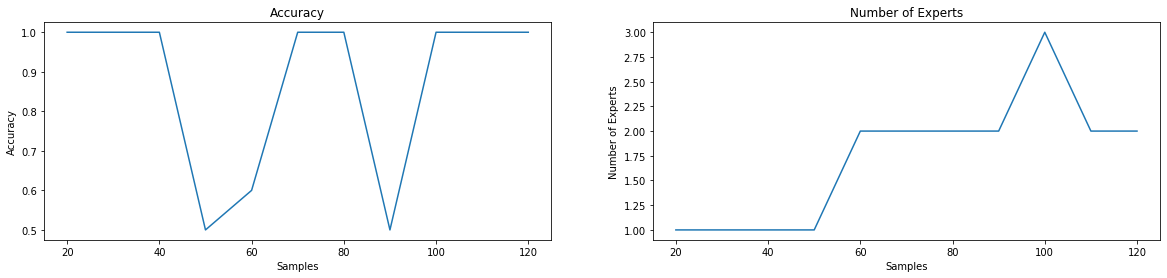







Mean Accuracy :  87.27272727272727 % 


Mean Number Of Experts :  1.7272727272727273






One Pass Time :  0.003421898682912191 m






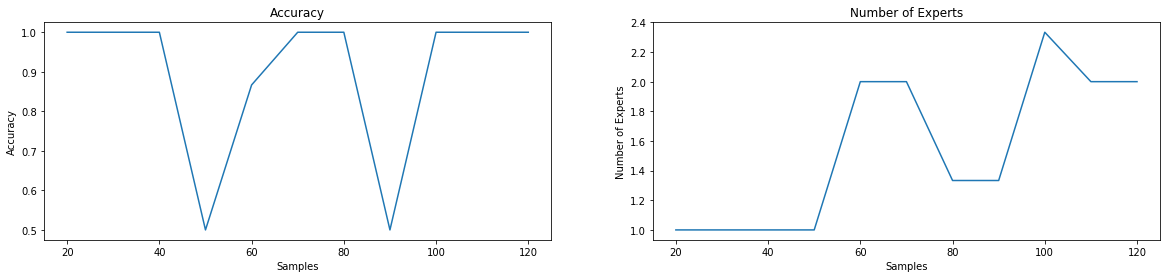







Mean Accuracy :  89.6969696969697 % 


Mean Number Of Experts :  1.5454545454545454






One Pass Time :  0.009126304255591498 m






In [21]:
Ex = DWM(Data=Features, Target=Labels, Beta=0.5, Threshold = 0.01, Period= 4, Interval=10, TestSamples= 10, AccType="BeforeTrain", BaseType="Rand")

Ex.Run_Mul(3)

## SEA Concept

### Generate SEA Concept

In [0]:
# Based on the SEA concept description

Size = 16000

b = [7, 8, 9, 9.5]

Quarter = int(Size/4)

Features = np.random.uniform(0, 10, (Size, 3))

Labels = np.ndarray([Size, 1])

Labels[:Quarter, 0] = Features[:Quarter, 0] + Features[:Quarter, 1] <= b[0]

Labels[Quarter:2*Quarter, 0] = Features[Quarter:2*Quarter, 0] + Features[Quarter:2*Quarter, 1] <= b[1]

Labels[2*Quarter:3*Quarter, 0] = Features[2*Quarter:3*Quarter, 0] + Features[2*Quarter:3*Quarter, 1] <= b[2]

Labels[3*Quarter:Size, 0] = Features[3*Quarter:Size, 0] + Features[3*Quarter:Size, 1] <= b[3]

Labels = Labels[:,0]

### One Learner

#### NB

In [23]:
OneLearner(Features, Labels, "NB", 80, 20)



Accuracy :  91.73366834170854 %




#### LG

In [24]:
OneLearner(Features, Labels, "LG", 80, 20)



Accuracy :  93.5929648241206 %




### NB Base Learners

The expert 1 was created.
The expert 2 was created.
The expert 3 was created.
The expert 4 was created.
The expert 5 was created.
The expert 6 was created.
The expert 7 was created.
The expert 8 was created.
100
The expert 9 was created.
The expert 10 was created.
The expert 11 was created.
The expert 12 was created.
The expert 7 was removed with weight :  0.0078125
11  Remaining experts.
200
The expert 13 was created.
The expert 11 was removed with weight :  0.0078125
11  Remaining experts.
The expert 14 was created.
300
The expert 12 was removed with weight :  0.0078125
11  Remaining experts.
The expert 15 was created.
The expert 6 was removed with weight :  0.0078125
11  Remaining experts.
The expert 16 was created.
The expert 14 was removed with weight :  0.0078125
11  Remaining experts.
The expert 17 was created.
400
The expert 18 was created.
The expert 15 was removed with weight :  0.0078125
12  Remaining experts.
The expert 19 was created.
The expert 10 was removed with weight 

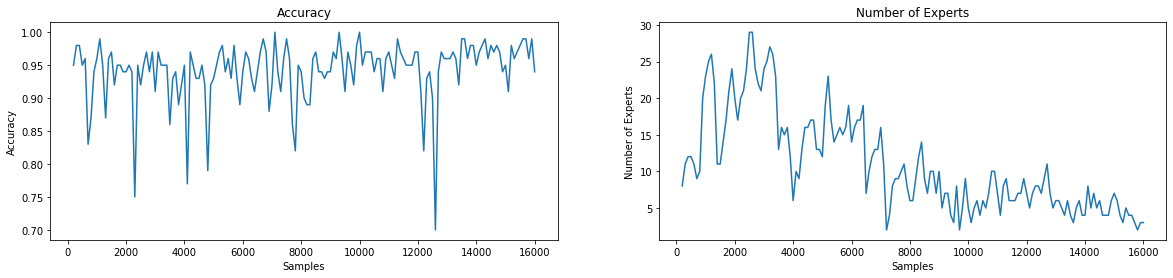







Mean Accuracy :  94.23899371069173 % 


Mean Number Of Experts :  10.89937106918239






One Pass Time :  2.49371102253596 m




The expert 1 was created.
The expert 2 was created.
The expert 3 was created.
The expert 4 was created.
The expert 5 was created.
The expert 6 was created.
The expert 7 was created.
The expert 8 was created.
100
The expert 9 was created.
The expert 10 was created.
The expert 11 was created.
The expert 7 was removed with weight :  0.0078125
10  Remaining experts.
200
The expert 12 was created.
The expert 13 was created.
The expert 14 was created.
300
The expert 10 was removed with weight :  0.0078125
12  Remaining experts.
The expert 11 was removed with weight :  0.0078125
11  Remaining experts.
The expert 15 was created.
The expert 16 was created.
The expert 13 was removed with weight :  0.0078125
12  Remaining experts.
The expert 14 was removed with weight :  0.0078125
11  Remaining experts.
400
The expert 17 was created.
The expert 15 was removed wit

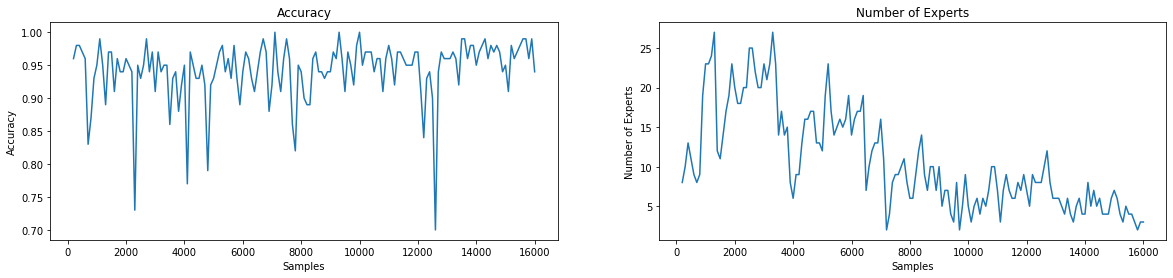







Mean Accuracy :  94.27044025157225 % 


Mean Number Of Experts :  10.69811320754717






One Pass Time :  2.402073641618093 m




The expert 1 was created.
The expert 2 was created.
The expert 3 was created.
The expert 4 was created.
The expert 5 was created.
The expert 6 was created.
The expert 7 was created.
The expert 8 was created.
100
The expert 9 was created.
The expert 10 was created.
The expert 11 was created.
The expert 7 was removed with weight :  0.0078125
10  Remaining experts.
200
The expert 12 was created.
The expert 13 was created.
The expert 14 was created.
300
The expert 10 was removed with weight :  0.0078125
12  Remaining experts.
The expert 11 was removed with weight :  0.0078125
11  Remaining experts.
The expert 15 was created.
The expert 16 was created.
The expert 13 was removed with weight :  0.0078125
12  Remaining experts.
The expert 14 was removed with weight :  0.0078125
11  Remaining experts.
400
The expert 17 was created.
The expert 15 was removed wi

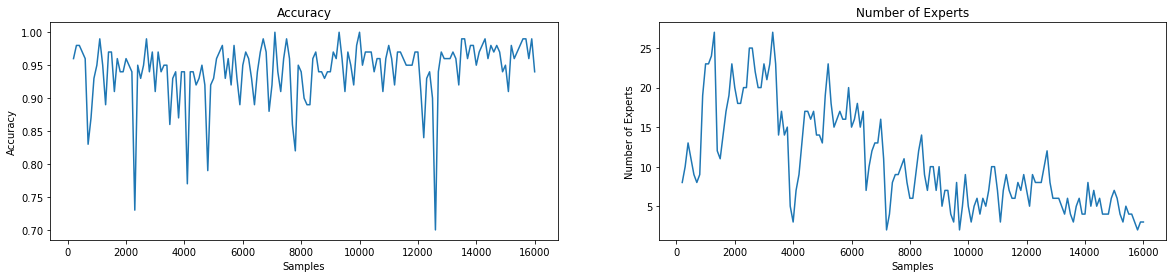







Mean Accuracy :  94.22641509433953 % 


Mean Number Of Experts :  10.69811320754717






One Pass Time :  2.367499641577403 m






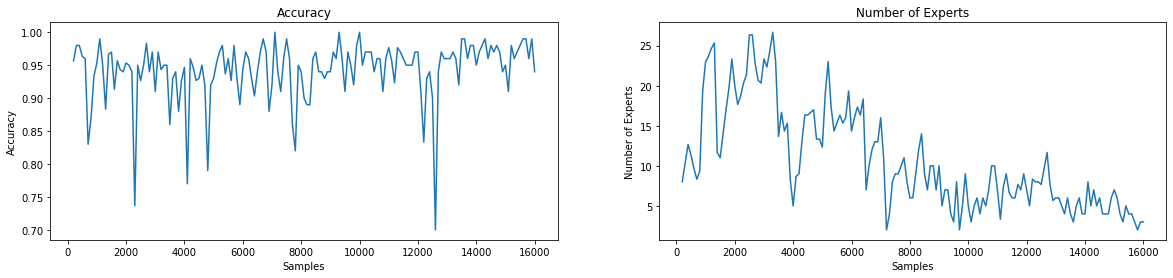







Mean Accuracy :  94.24528301886784 % 


Mean Number Of Experts :  10.76519916142558






One Pass Time :  2.4260348492198522 m






In [25]:
Ex = DWM(Data=Features, Target=Labels, Beta=0.5, Threshold = 0.01, Period= 1, Interval=100, TestSamples= 100, AccType="BeforeTrain", BaseType="NB")

Ex.Run_Mul(3)

The expert 1 was created.
The expert 2 was created.
The expert 3 was created.
The expert 4 was created.
The expert 5 was created.
100
200
The expert 5 was removed with weight :  0.0078125
4  Remaining experts.
The expert 6 was created.
300
The expert 7 was created.
400
The expert 8 was created.
The expert 9 was created.
The expert 10 was created.
The expert 11 was created.
500
The expert 12 was created.
The expert 13 was created.
The expert 6 was removed with weight :  0.0078125
11  Remaining experts.
The expert 14 was created.
600
The expert 4 was removed with weight :  0.0078125
11  Remaining experts.
The expert 8 was removed with weight :  0.0078125
10  Remaining experts.
The expert 15 was created.
The expert 11 was removed with weight :  0.0078125
10  Remaining experts.
The expert 16 was created.
The expert 7 was removed with weight :  0.0078125
10  Remaining experts.
The expert 9 was removed with weight :  0.0078125
9  Remaining experts.
The expert 10 was removed with weight :  0.

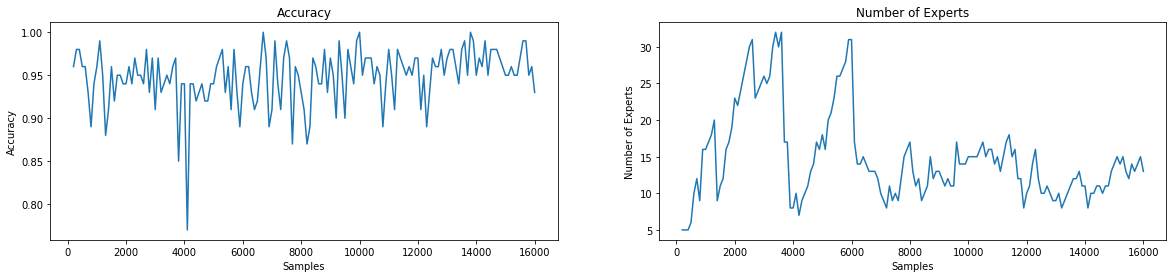







Mean Accuracy :  94.86163522012573 % 


Mean Number Of Experts :  14.849056603773585






One Pass Time :  3.6910249471664427 m




The expert 1 was created.
The expert 2 was created.
The expert 3 was created.
The expert 4 was created.
The expert 5 was created.
100
200
The expert 5 was removed with weight :  0.0078125
4  Remaining experts.
The expert 6 was created.
300
The expert 7 was created.
400
The expert 8 was created.
The expert 9 was created.
The expert 10 was created.
The expert 11 was created.
500
The expert 12 was created.
The expert 13 was created.
The expert 6 was removed with weight :  0.0078125
11  Remaining experts.
The expert 14 was created.
600
The expert 4 was removed with weight :  0.0078125
11  Remaining experts.
The expert 8 was removed with weight :  0.0078125
10  Remaining experts.
The expert 15 was created.
The expert 11 was removed with weight :  0.0078125
10  Remaining experts.
The expert 16 was created.
The expert 7 was removed with weight :  0.0078125

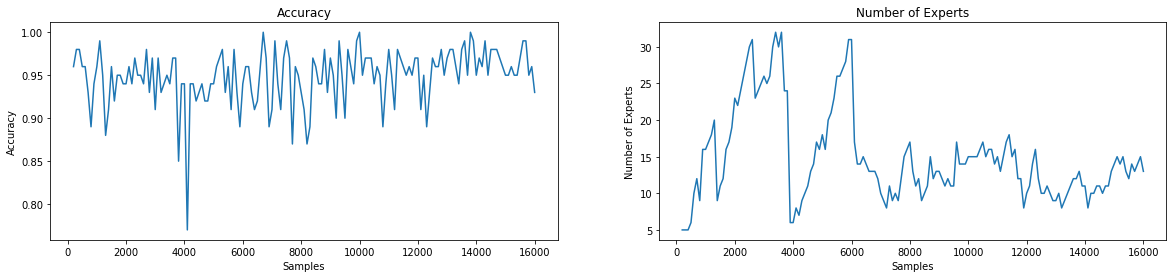







Mean Accuracy :  94.86792452830184 % 


Mean Number Of Experts :  14.89937106918239






One Pass Time :  3.7341855565706887 m




The expert 1 was created.
The expert 2 was created.
The expert 3 was created.
The expert 4 was created.
The expert 5 was created.
100
200
The expert 5 was removed with weight :  0.0078125
4  Remaining experts.
The expert 6 was created.
300
The expert 7 was created.
400
The expert 8 was created.
The expert 9 was created.
The expert 10 was created.
The expert 11 was created.
500
The expert 12 was created.
The expert 13 was created.
The expert 6 was removed with weight :  0.0078125
11  Remaining experts.
The expert 14 was created.
600
The expert 4 was removed with weight :  0.0078125
11  Remaining experts.
The expert 8 was removed with weight :  0.0078125
10  Remaining experts.
The expert 15 was created.
The expert 11 was removed with weight :  0.0078125
10  Remaining experts.
The expert 16 was created.
The expert 7 was removed with weight :  0.0078125


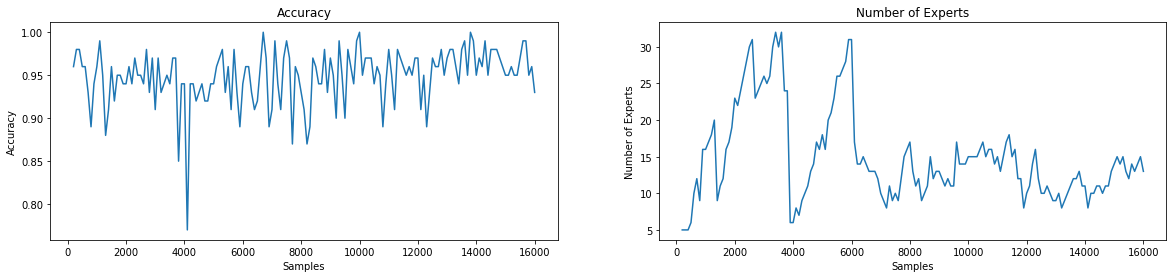







Mean Accuracy :  94.86792452830184 % 


Mean Number Of Experts :  14.89937106918239






One Pass Time :  3.732953417301178 m






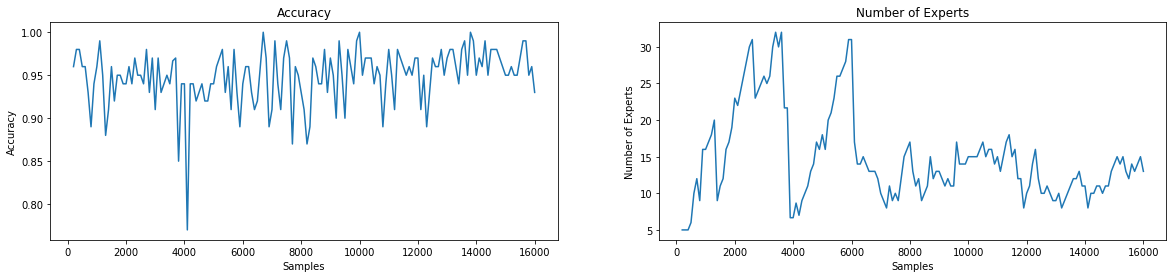







Mean Accuracy :  94.86582809224313 % 


Mean Number Of Experts :  14.882599580712787






One Pass Time :  3.7241654250356886 m






In [26]:
Ex = DWM(Data=Features, Target=Labels, Beta=0.5, Threshold = 0.01, Period= 2, Interval=100, TestSamples= 100, AccType="BeforeTrain", BaseType="NB")

Ex.Run_Mul(3)

The expert 1 was created.
The expert 2 was created.
100
200
300
The expert 3 was created.
400
The expert 4 was created.
The expert 5 was created.
500
The expert 6 was created.
600
The expert 7 was created.
The expert 8 was created.
700
The expert 9 was created.
The expert 10 was created.
The expert 11 was created.
The expert 12 was created.
The expert 13 was created.
800
The expert 14 was created.
The expert 15 was created.
900
The expert 16 was created.
1000
1100
The expert 17 was created.
The expert 18 was created.
The expert 19 was created.
1200
The expert 20 was created.
The expert 4 was removed with weight :  0.0078125
19  Remaining experts.
The expert 21 was created.
The expert 22 was created.
The expert 3 was removed with weight :  0.0078125
20  Remaining experts.
The expert 6 was removed with weight :  0.0078125
19  Remaining experts.
The expert 7 was removed with weight :  0.0078125
18  Remaining experts.
The expert 8 was removed with weight :  0.0078125
17  Remaining experts.

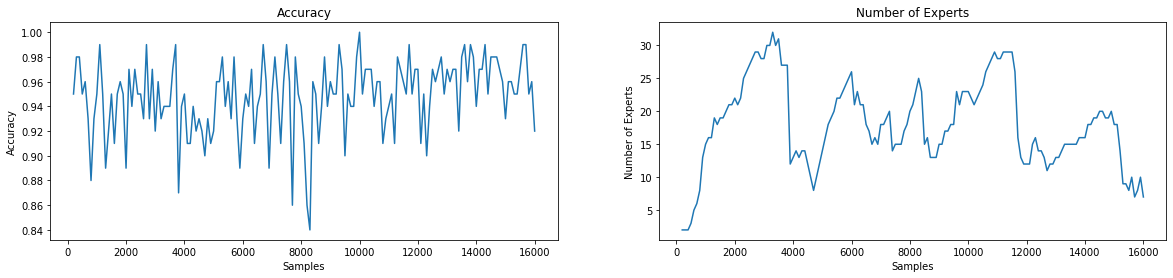







Mean Accuracy :  94.81761006289302 % 


Mean Number Of Experts :  18.11949685534591






One Pass Time :  5.288802639643351 m




The expert 1 was created.
The expert 2 was created.
100
200
300
The expert 3 was created.
400
The expert 4 was created.
The expert 5 was created.
500
The expert 6 was created.
600
The expert 7 was created.
The expert 8 was created.
700
The expert 9 was created.
The expert 10 was created.
The expert 11 was created.
The expert 12 was created.
The expert 13 was created.
800
The expert 14 was created.
The expert 15 was created.
900
The expert 16 was created.
1000
1100
The expert 17 was created.
The expert 18 was created.
The expert 19 was created.
1200
The expert 20 was created.
The expert 4 was removed with weight :  0.0078125
19  Remaining experts.
The expert 21 was created.
The expert 22 was created.
The expert 3 was removed with weight :  0.0078125
20  Remaining experts.
The expert 6 was removed with weight :  0.0078125
19  Remaining experts.
The expe

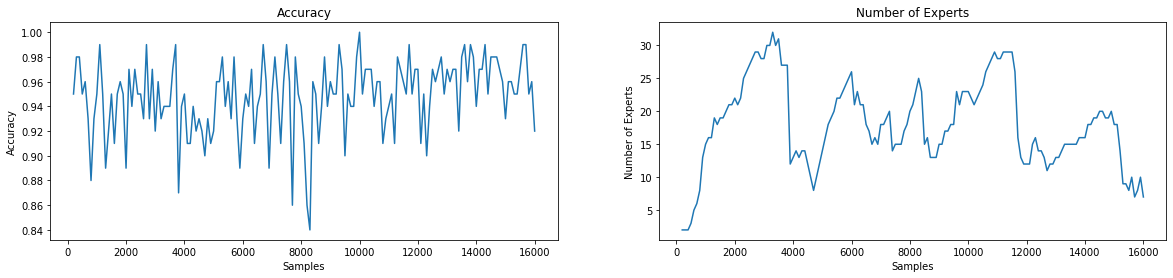







Mean Accuracy :  94.81761006289302 % 


Mean Number Of Experts :  18.11949685534591






One Pass Time :  5.251505049069722 m




The expert 1 was created.
The expert 2 was created.
100
200
300
The expert 3 was created.
400
The expert 4 was created.
The expert 5 was created.
500
The expert 6 was created.
600
The expert 7 was created.
The expert 8 was created.
700
The expert 9 was created.
The expert 10 was created.
The expert 11 was created.
The expert 12 was created.
The expert 13 was created.
800
The expert 14 was created.
The expert 15 was created.
900
The expert 16 was created.
1000
1100
The expert 17 was created.
The expert 18 was created.
The expert 19 was created.
1200
The expert 20 was created.
The expert 4 was removed with weight :  0.0078125
19  Remaining experts.
The expert 21 was created.
The expert 22 was created.
The expert 3 was removed with weight :  0.0078125
20  Remaining experts.
The expert 6 was removed with weight :  0.0078125
19  Remaining experts.
The expe

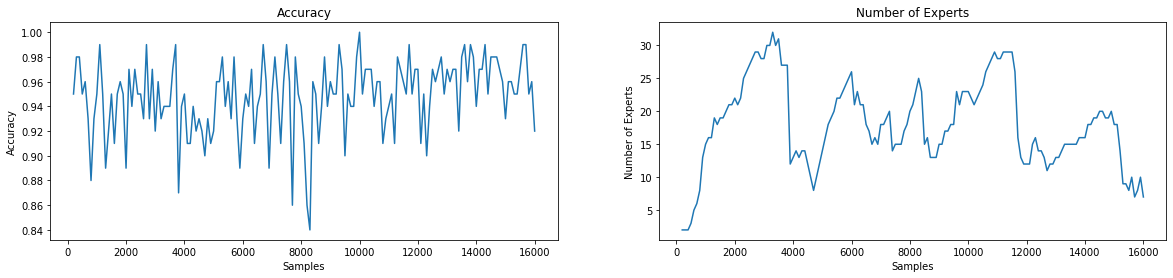







Mean Accuracy :  94.81761006289302 % 


Mean Number Of Experts :  18.11949685534591






One Pass Time :  5.2689701040585835 m






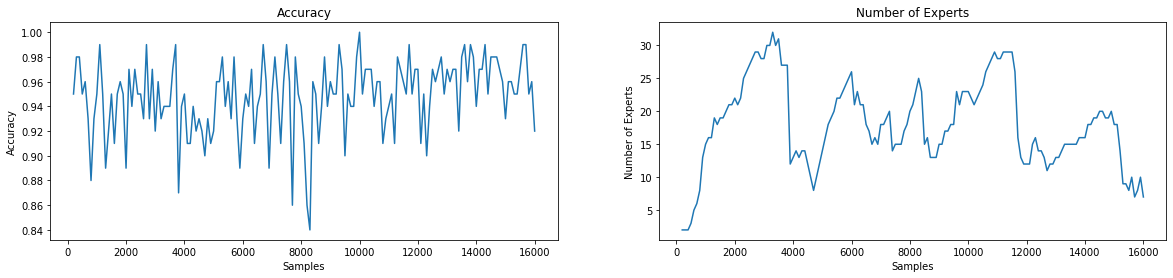







Mean Accuracy :  94.81761006289302 % 


Mean Number Of Experts :  18.11949685534591






One Pass Time :  5.275203837288751 m






In [27]:
Ex = DWM(Data=Features, Target=Labels, Beta=0.5, Threshold = 0.01, Period= 4, Interval=100, TestSamples= 100, AccType="BeforeTrain", BaseType="NB")

Ex.Run_Mul(3)

The expert 1 was created.
The expert 2 was created.
100
200
300
400
The expert 3 was created.
The expert 4 was created.
500
600
The expert 5 was created.
The expert 6 was created.
700
The expert 7 was created.
The expert 8 was created.
The expert 9 was created.
800
The expert 10 was created.
900
1000
1100
The expert 11 was created.
1200
The expert 12 was created.
The expert 13 was created.
1300
1400
1500
1600
The expert 14 was created.
1700
1800
1900
2000
2100
The expert 15 was created.
2200
The expert 16 was created.
2300
The expert 17 was created.
2400
The expert 18 was created.
2500
The expert 3 was removed with weight :  0.0078125
17  Remaining experts.
The expert 19 was created.
2600
2700
2800
2900
The expert 20 was created.
3000
3100
The expert 21 was created.
3200
The expert 22 was created.
3300
3400
The expert 23 was created.
3500
3600
3700
The expert 24 was created.
The expert 1 was removed with weight :  0.0078125
22  Remaining experts.
The expert 2 was removed with weight : 

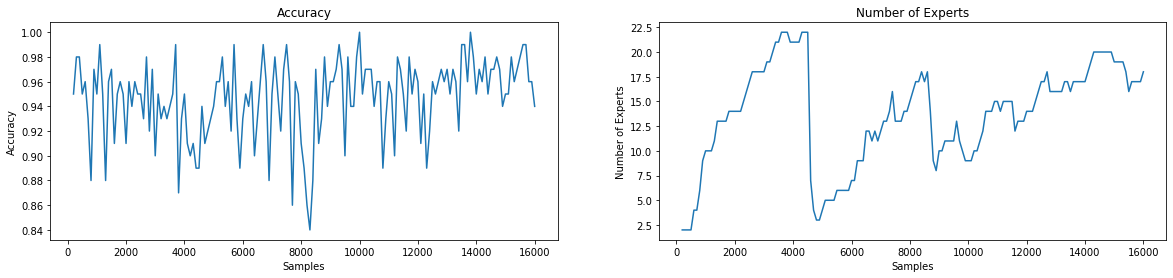







Mean Accuracy :  94.67924528301879 % 


Mean Number Of Experts :  13.71069182389937






One Pass Time :  4.740790220101674 m




The expert 1 was created.
The expert 2 was created.
100
200
300
400
The expert 3 was created.
The expert 4 was created.
500
600
The expert 5 was created.
The expert 6 was created.
700
The expert 7 was created.
The expert 8 was created.
The expert 9 was created.
800
The expert 10 was created.
900
1000
1100
The expert 11 was created.
1200
The expert 12 was created.
The expert 13 was created.
1300
1400
1500
1600
The expert 14 was created.
1700
1800
1900
2000
2100
The expert 15 was created.
2200
The expert 16 was created.
2300
The expert 17 was created.
2400
The expert 18 was created.
2500
The expert 3 was removed with weight :  0.0078125
17  Remaining experts.
The expert 19 was created.
2600
2700
2800
2900
The expert 20 was created.
3000
3100
The expert 21 was created.
3200
The expert 22 was created.
3300
3400
The expert 23 was created.
3500
3600
3700
Th

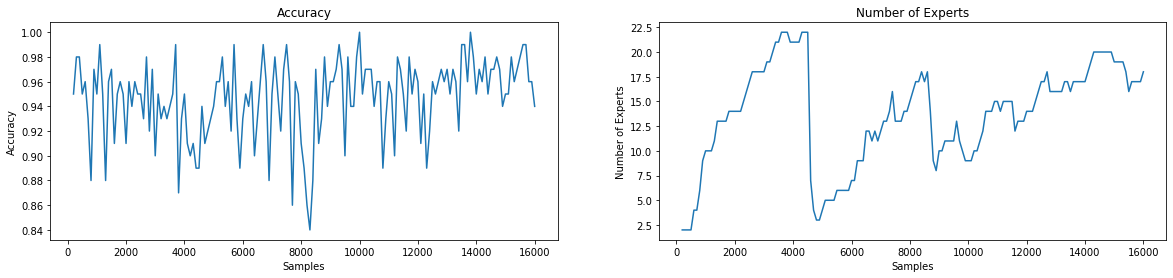







Mean Accuracy :  94.67924528301879 % 


Mean Number Of Experts :  13.71069182389937






One Pass Time :  4.7305169383684795 m




The expert 1 was created.
The expert 2 was created.
100
200
300
400
The expert 3 was created.
The expert 4 was created.
500
600
The expert 5 was created.
The expert 6 was created.
700
The expert 7 was created.
The expert 8 was created.
The expert 9 was created.
800
The expert 10 was created.
900
1000
1100
The expert 11 was created.
1200
The expert 12 was created.
The expert 13 was created.
1300
1400
1500
1600
The expert 14 was created.
1700
1800
1900
2000
2100
The expert 15 was created.
2200
The expert 16 was created.
2300
The expert 17 was created.
2400
The expert 18 was created.
2500
The expert 3 was removed with weight :  0.0078125
17  Remaining experts.
The expert 19 was created.
2600
2700
2800
2900
The expert 20 was created.
3000
3100
The expert 21 was created.
3200
The expert 22 was created.
3300
3400
The expert 23 was created.
3500
3600
3700
T

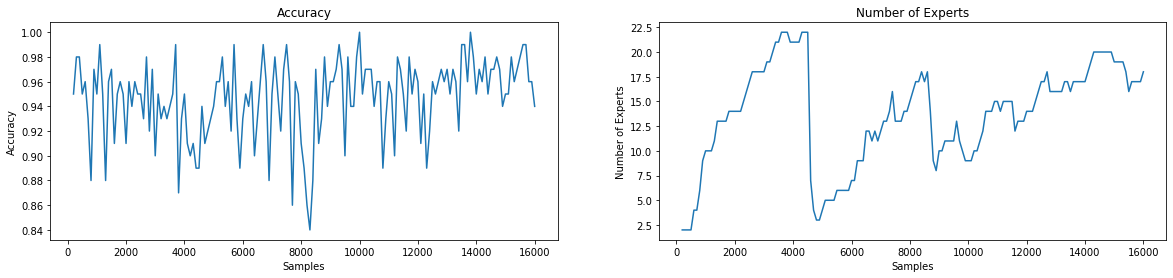







Mean Accuracy :  94.67924528301879 % 


Mean Number Of Experts :  13.71069182389937






One Pass Time :  4.739514414469401 m






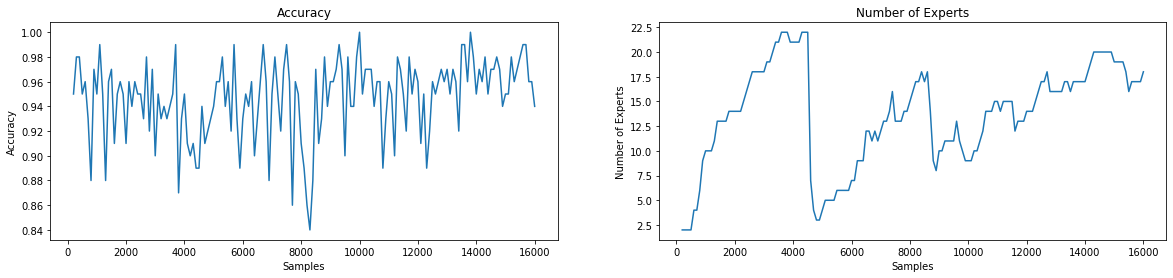







Mean Accuracy :  94.67924528301879 % 


Mean Number Of Experts :  13.71069182389937






One Pass Time :  4.742209687497881 m






In [28]:
Ex = DWM(Data=Features, Target=Labels, Beta=0.5, Threshold = 0.01, Period= 8, Interval=100, TestSamples= 100, AccType="BeforeTrain", BaseType="NB")

Ex.Run_Mul(3)

### LG Base Learners

The expert 1 was created.
The expert 2 was created.
The expert 3 was created.
The expert 4 was created.
100
The expert 5 was created.
The expert 6 was created.
The expert 7 was created.
The expert 8 was created.
200
The expert 9 was created.
300
The expert 10 was created.
400
500
The expert 11 was created.
The expert 12 was created.
The expert 13 was created.
600
700
The expert 11 was removed with weight :  0.0078125
12  Remaining experts.
The expert 12 was removed with weight :  0.0078125
11  Remaining experts.
The expert 13 was removed with weight :  0.0078125
10  Remaining experts.
800
The expert 10 was removed with weight :  0.0078125
9  Remaining experts.
900
1000
1100
1200
The expert 14 was created.
The expert 15 was created.
1300
The expert 16 was created.
1400
The expert 15 was removed with weight :  0.0078125
11  Remaining experts.
1500
1600
1700
The expert 16 was removed with weight :  0.0078125
10  Remaining experts.
1800
1900
2000
2100
The expert 17 was created.
2200
The ex

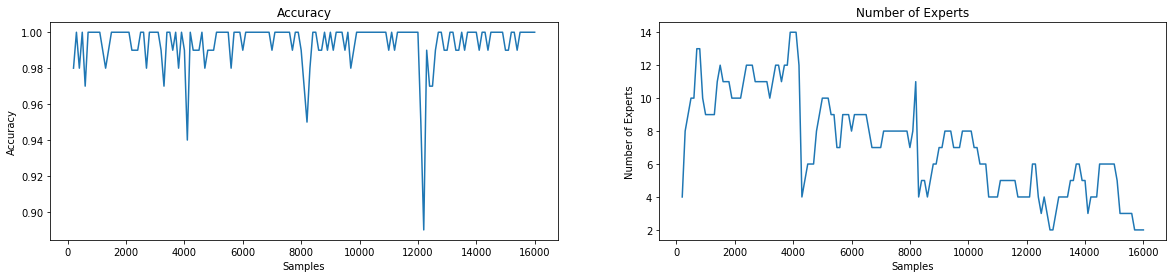







Mean Accuracy :  99.38364779874215 % 


Mean Number Of Experts :  7.226415094339623






One Pass Time :  16.837060980002086 m




The expert 1 was created.
The expert 2 was created.
The expert 3 was created.
The expert 4 was created.
100
The expert 5 was created.
The expert 6 was created.
The expert 7 was created.
200
300
The expert 8 was created.
400
500
The expert 9 was created.
The expert 10 was created.
The expert 11 was created.
600
700
The expert 9 was removed with weight :  0.0078125
10  Remaining experts.
The expert 10 was removed with weight :  0.0078125
9  Remaining experts.
The expert 11 was removed with weight :  0.0078125
8  Remaining experts.
800
The expert 8 was removed with weight :  0.0078125
7  Remaining experts.
900
1000
1100
1200
The expert 12 was created.
The expert 13 was created.
1300
The expert 14 was created.
1400
The expert 13 was removed with weight :  0.0078125
9  Remaining experts.
1500
1600
1700
The expert 14 was removed with weight :  0.0078125
8 

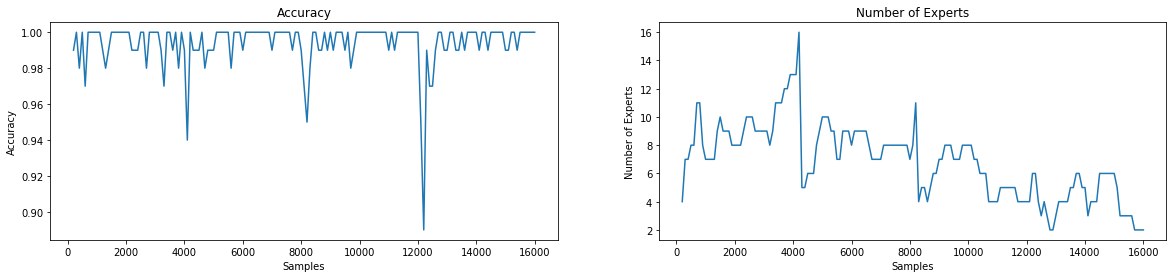







Mean Accuracy :  99.38993710691824 % 


Mean Number Of Experts :  6.8427672955974845






One Pass Time :  15.773281002044678 m




The expert 1 was created.
The expert 2 was created.
The expert 3 was created.
The expert 4 was created.
100
The expert 5 was created.
The expert 6 was created.
The expert 7 was created.
200
300
The expert 8 was created.
400
500
The expert 9 was created.
The expert 10 was created.
The expert 11 was created.
600
700
The expert 9 was removed with weight :  0.0078125
10  Remaining experts.
The expert 10 was removed with weight :  0.0078125
9  Remaining experts.
The expert 11 was removed with weight :  0.0078125
8  Remaining experts.
800
The expert 8 was removed with weight :  0.0078125
7  Remaining experts.
900
1000
1100
1200
The expert 12 was created.
The expert 13 was created.
1300
The expert 14 was created.
1400
The expert 13 was removed with weight :  0.0078125
9  Remaining experts.
1500
1600
1700
The expert 14 was removed with weight :  0.0078125
8

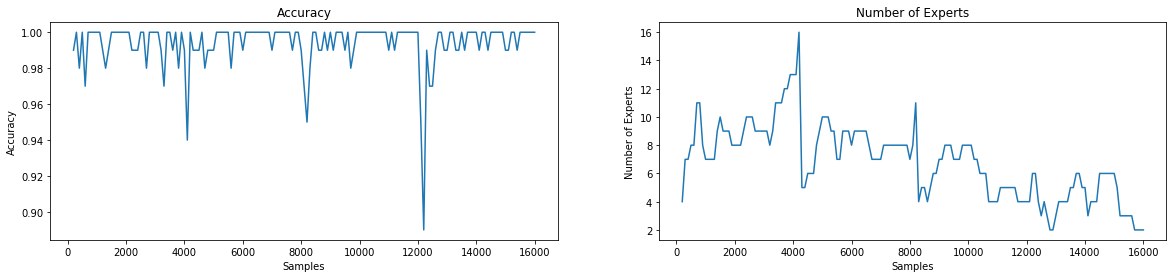







Mean Accuracy :  99.38993710691824 % 


Mean Number Of Experts :  6.8427672955974845






One Pass Time :  15.795643810431162 m






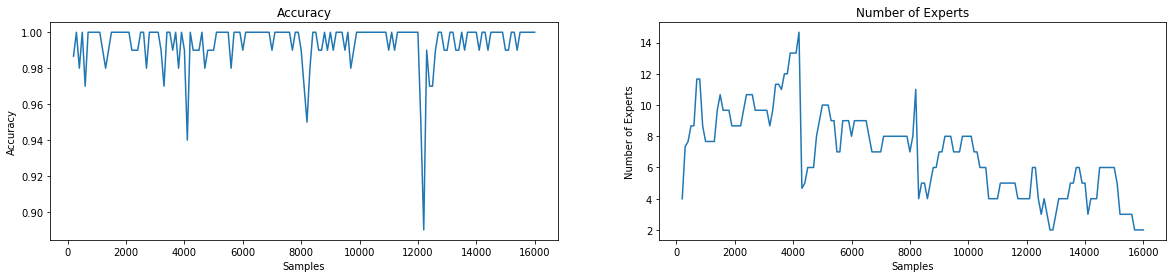







Mean Accuracy :  99.38784067085955 % 


Mean Number Of Experts :  6.970649895178196






One Pass Time :  16.140755330191716 m






In [29]:
Ex = DWM(Data=Features, Target=Labels, Beta=0.5, Threshold = 0.01, Period= 1, Interval=100, TestSamples= 100, AccType="BeforeTrain", BaseType="LG")

Ex.Run_Mul(3)

The expert 1 was created.
The expert 2 was created.
The expert 3 was created.
100
The expert 4 was created.
200
300
400
500
The expert 5 was created.
600
700
800
900
1000
1100
1200
The expert 6 was created.
1300
1400
1500
1600
1700
1800
1900
2000
2100
The expert 7 was created.
2200
The expert 8 was created.
2300
2400
2500
2600
The expert 9 was created.
2700
2800
2900
3000
3100
3200
The expert 6 was removed with weight :  0.0078125
8  Remaining experts.
The expert 10 was created.
3300
3400
3500
The expert 11 was created.
3600
3700
3800
3900
The expert 12 was created.
4000
The expert 13 was created.
The expert 9 was removed with weight :  0.0078125
11  Remaining experts.
The expert 11 was removed with weight :  0.0078125
10  Remaining experts.
The expert 14 was created.
4100
The expert 5 was removed with weight :  0.0078125
10  Remaining experts.
The expert 7 was removed with weight :  0.0078125
9  Remaining experts.
The expert 8 was removed with weight :  0.0078125
8  Remaining experts.

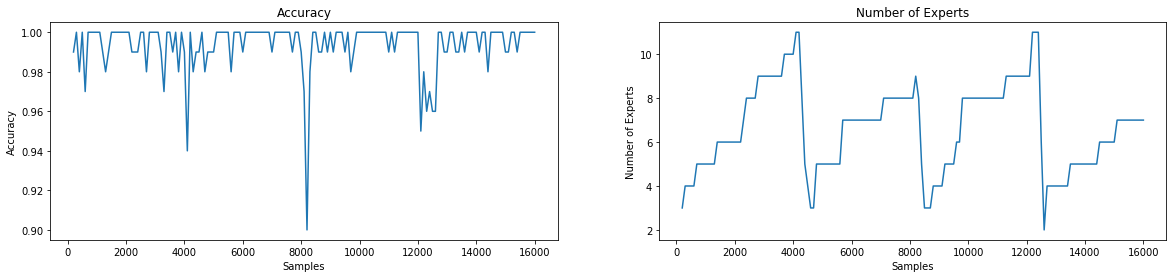







Mean Accuracy :  99.35849056603773 % 


Mean Number Of Experts :  6.622641509433962






One Pass Time :  17.0140948732694 m




The expert 1 was created.
The expert 2 was created.
The expert 3 was created.
100
The expert 4 was created.
200
300
400
500
The expert 5 was created.
600
700
800
900
1000
1100
1200
The expert 6 was created.
1300
1400
1500
1600
1700
1800
1900
2000
2100
The expert 7 was created.
2200
The expert 8 was created.
2300
2400
2500
2600
The expert 9 was created.
2700
2800
2900
3000
3100
3200
The expert 6 was removed with weight :  0.0078125
8  Remaining experts.
The expert 10 was created.
3300
3400
3500
The expert 11 was created.
3600
3700
3800
3900
The expert 12 was created.
4000
The expert 13 was created.
The expert 9 was removed with weight :  0.0078125
11  Remaining experts.
The expert 11 was removed with weight :  0.0078125
10  Remaining experts.
The expert 14 was created.
4100
The expert 5 was removed with weight :  0.0078125
10  Remaining experts.
The exp

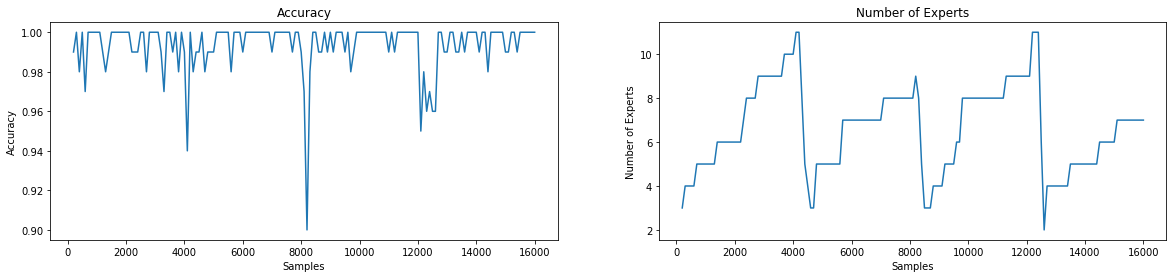







Mean Accuracy :  99.35849056603773 % 


Mean Number Of Experts :  6.622641509433962






One Pass Time :  16.890966852506 m




The expert 1 was created.
The expert 2 was created.
The expert 3 was created.
100
The expert 4 was created.
200
300
400
500
The expert 5 was created.
600
700
800
900
1000
1100
1200
The expert 6 was created.
1300
1400
1500
1600
1700
1800
1900
2000
2100
The expert 7 was created.
2200
The expert 8 was created.
2300
2400
2500
2600
The expert 9 was created.
2700
2800
2900
3000
3100
3200
The expert 6 was removed with weight :  0.0078125
8  Remaining experts.
The expert 10 was created.
3300
3400
3500
The expert 11 was created.
3600
3700
3800
3900
The expert 12 was created.
4000
The expert 13 was created.
The expert 9 was removed with weight :  0.0078125
11  Remaining experts.
The expert 11 was removed with weight :  0.0078125
10  Remaining experts.
The expert 14 was created.
4100
The expert 5 was removed with weight :  0.0078125
10  Remaining experts.
The expe

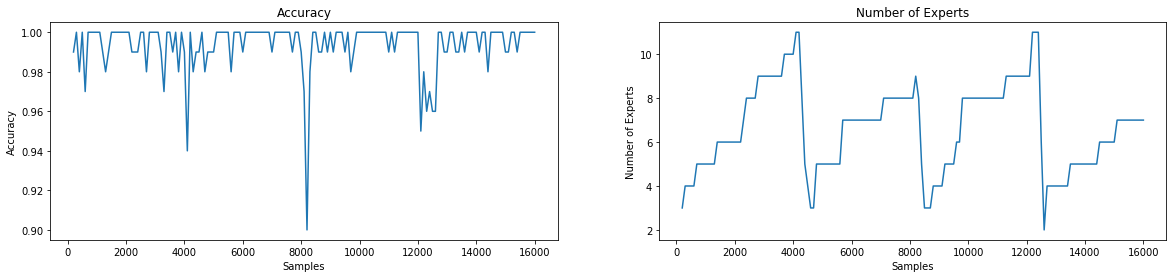







Mean Accuracy :  99.35849056603773 % 


Mean Number Of Experts :  6.622641509433962






One Pass Time :  16.80312074025472 m






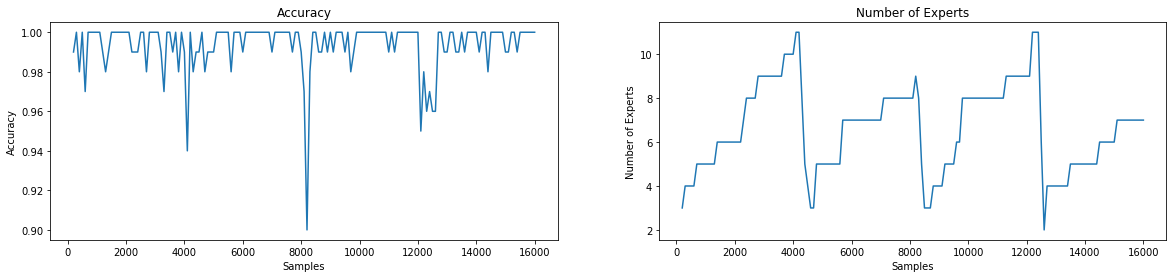







Mean Accuracy :  99.35849056603773 % 


Mean Number Of Experts :  6.622641509433962






One Pass Time :  16.908198204305435 m






In [30]:
Ex = DWM(Data=Features, Target=Labels, Beta=0.5, Threshold = 0.01, Period= 2, Interval=100, TestSamples= 100, AccType="BeforeTrain", BaseType="LG")

Ex.Run_Mul(3)

The expert 1 was created.
100
200
300
400
500
600
700
800
900
1000
1100
1200
The expert 2 was created.
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
The expert 3 was created.
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
The expert 4 was created.
3300
3400
3500
3600
3700
3800
3900
The expert 5 was created.
4000
The expert 6 was created.
4100
4200
4300
4400
The expert 2 was removed with weight :  0.0078125
5  Remaining experts.
4500
The expert 1 was removed with weight :  0.0078125
4  Remaining experts.
The expert 3 was removed with weight :  0.0078125
3  Remaining experts.
4600
The expert 7 was created.
4700
4800
4900
The expert 4 was removed with weight :  0.0078125
3  Remaining experts.
5000
The expert 8 was created.
5100
5200
5300
5400
5500
The expert 9 was created.
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
The expert 10 was created.
8100
The expert 11 was created.
The expert 8 was removed wit

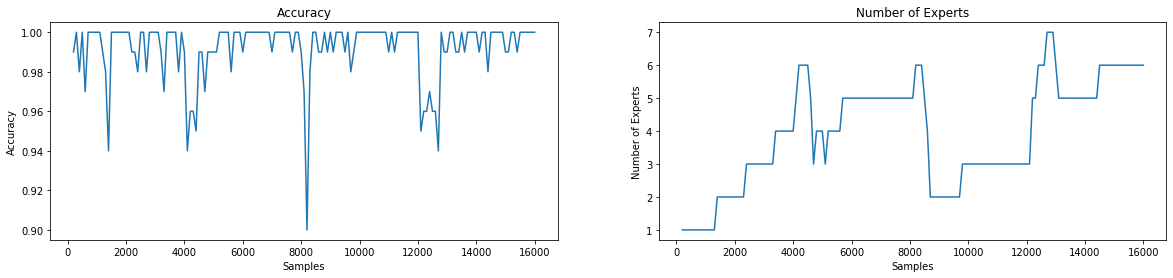







Mean Accuracy :  99.19496855345912 % 


Mean Number Of Experts :  3.9559748427672954






One Pass Time :  10.895283802350361 m




The expert 1 was created.
100
200
300
400
500
600
700
800
900
1000
1100
1200
The expert 2 was created.
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
The expert 3 was created.
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
The expert 4 was created.
3300
3400
3500
3600
3700
3800
3900
The expert 5 was created.
4000
The expert 6 was created.
4100
4200
4300
4400
The expert 2 was removed with weight :  0.0078125
5  Remaining experts.
4500
The expert 1 was removed with weight :  0.0078125
4  Remaining experts.
The expert 3 was removed with weight :  0.0078125
3  Remaining experts.
4600
The expert 7 was created.
4700
4800
4900
The expert 4 was removed with weight :  0.0078125
3  Remaining experts.
5000
The expert 8 was created.
5100
5200
5300
5400
5500
The expert 9 was created.
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
700

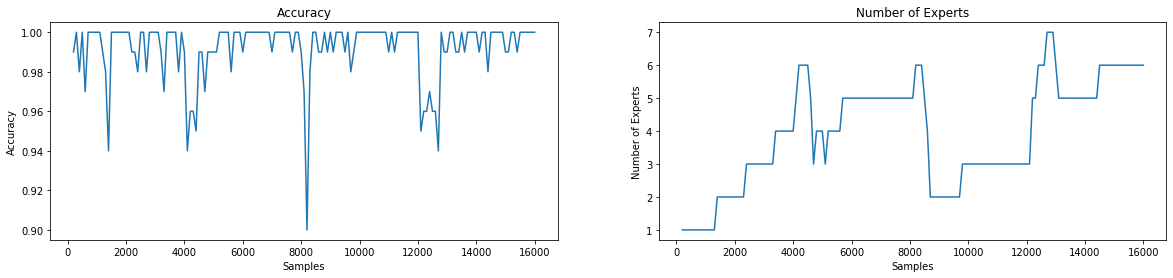







Mean Accuracy :  99.19496855345912 % 


Mean Number Of Experts :  3.9559748427672954






One Pass Time :  10.899482953548432 m




The expert 1 was created.
100
200
300
400
500
600
700
800
900
1000
1100
1200
The expert 2 was created.
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
The expert 3 was created.
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
The expert 4 was created.
3300
3400
3500
3600
3700
3800
3900
The expert 5 was created.
4000
The expert 6 was created.
4100
4200
4300
4400
The expert 2 was removed with weight :  0.0078125
5  Remaining experts.
4500
The expert 1 was removed with weight :  0.0078125
4  Remaining experts.
The expert 3 was removed with weight :  0.0078125
3  Remaining experts.
4600
The expert 7 was created.
4700
4800
4900
The expert 4 was removed with weight :  0.0078125
3  Remaining experts.
5000
The expert 8 was created.
5100
5200
5300
5400
5500
The expert 9 was created.
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
700

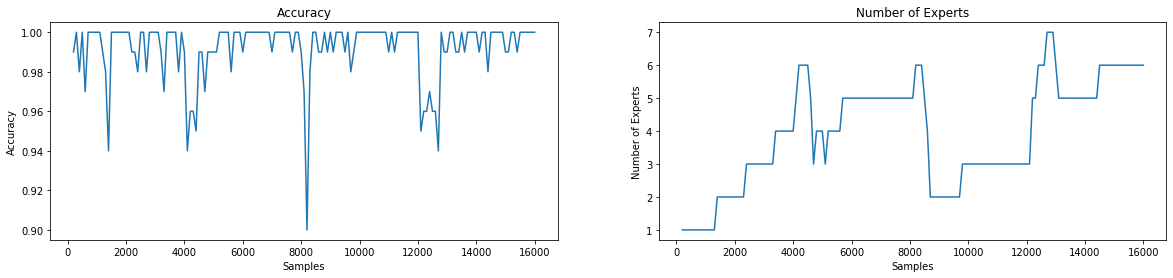







Mean Accuracy :  99.19496855345912 % 


Mean Number Of Experts :  3.9559748427672954






One Pass Time :  10.916076083978018 m






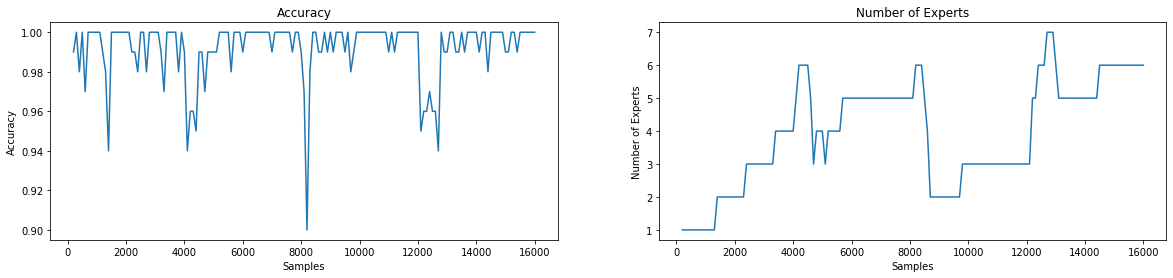







Mean Accuracy :  99.19496855345912 % 


Mean Number Of Experts :  3.9559748427672954






One Pass Time :  10.909065663814545 m






In [31]:
Ex = DWM(Data=Features, Target=Labels, Beta=0.5, Threshold = 0.01, Period= 4, Interval=100, TestSamples= 100, AccType="BeforeTrain", BaseType="LG")

Ex.Run_Mul(3)

### LG and NB Base Learners

The expert 1 was created.
The expert 2 was created.
The expert 3 was created.
The expert 4 was created.
The expert 5 was created.
The expert 6 was created.
100
The expert 5 was removed with weight :  0.0078125
5  Remaining experts.
The expert 1 was removed with weight :  0.0078125
4  Remaining experts.
The expert 2 was removed with weight :  0.0078125
3  Remaining experts.
The expert 7 was created.
The expert 8 was created.
200
The expert 9 was created.
300
The expert 9 was removed with weight :  0.0078125
5  Remaining experts.
The expert 10 was created.
400
The expert 3 was removed with weight :  0.0078125
5  Remaining experts.
500
The expert 11 was created.
The expert 12 was created.
The expert 13 was created.
The expert 11 was removed with weight :  0.0078125
7  Remaining experts.
600
The expert 12 was removed with weight :  0.0078125
6  Remaining experts.
700
The expert 13 was removed with weight :  0.0078125
5  Remaining experts.
800
The expert 10 was removed with weight :  0.0078

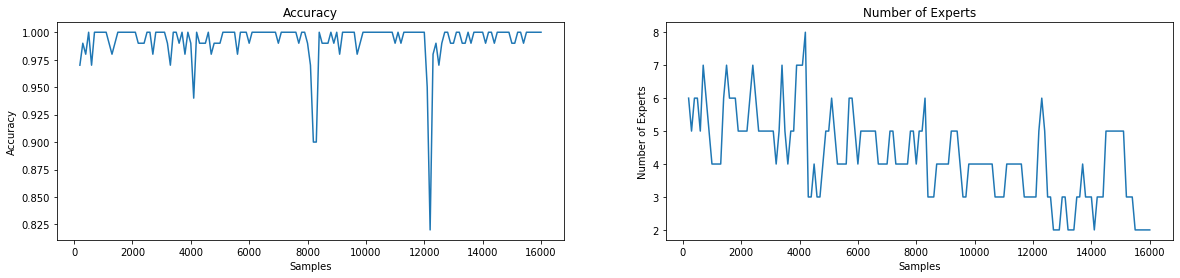







Mean Accuracy :  99.24528301886794 % 


Mean Number Of Experts :  4.2578616352201255






One Pass Time :  9.630608542760212 m




The expert 1 was created.
The expert 2 was created.
The expert 3 was created.
The expert 4 was created.
100
The expert 3 was removed with weight :  0.0078125
3  Remaining experts.
The expert 4 was removed with weight :  0.0078125
2  Remaining experts.
The expert 5 was created.
The expert 6 was created.
The expert 7 was created.
200
The expert 8 was created.
300
The expert 7 was removed with weight :  0.0078125
5  Remaining experts.
The expert 9 was created.
400
500
The expert 10 was created.
The expert 11 was created.
The expert 12 was created.
The expert 10 was removed with weight :  0.0078125
8  Remaining experts.
600
700
The expert 11 was removed with weight :  0.0078125
7  Remaining experts.
The expert 12 was removed with weight :  0.0078125
6  Remaining experts.
The expert 9 was removed with weight :  0.0078125
5  Remaining experts.
800
900
1000

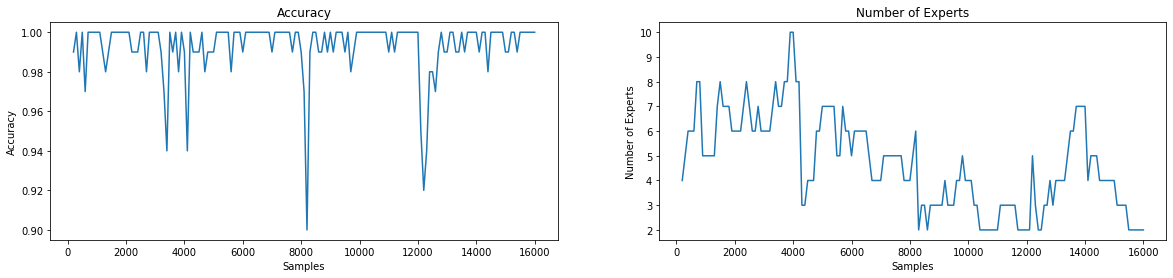







Mean Accuracy :  99.30188679245282 % 


Mean Number Of Experts :  4.6918238993710695






One Pass Time :  10.27789824406306 m




The expert 1 was created.
The expert 2 was created.
The expert 3 was created.
The expert 4 was created.
The expert 5 was created.
The expert 4 was removed with weight :  0.0078125
4  Remaining experts.
100
The expert 1 was removed with weight :  0.0078125
3  Remaining experts.
The expert 2 was removed with weight :  0.0078125
2  Remaining experts.
The expert 5 was removed with weight :  0.0078125
1  Remaining experts.
The expert 6 was created.
The expert 7 was created.
The expert 8 was created.
200
The expert 7 was removed with weight :  0.0078125
3  Remaining experts.
The expert 9 was created.
300
The expert 8 was removed with weight :  0.0078125
3  Remaining experts.
The expert 9 was removed with weight :  0.0078125
2  Remaining experts.
The expert 10 was created.
400
The expert 10 was removed with weight :  0.0078125
2  Remaining experts.
500
The 

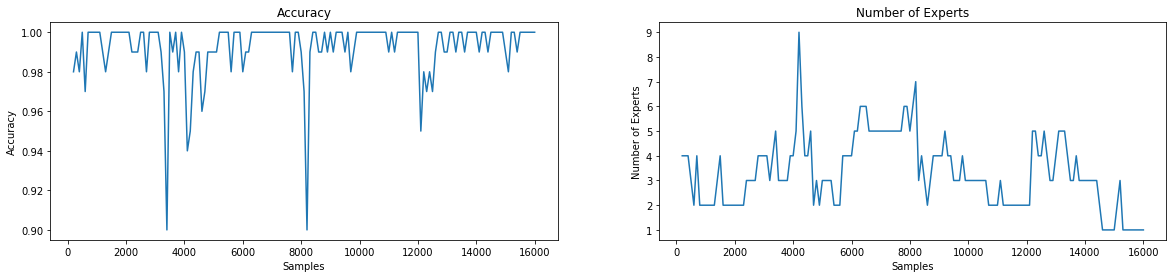







Mean Accuracy :  99.24528301886794 % 


Mean Number Of Experts :  3.3144654088050314






One Pass Time :  7.230199627081553 m






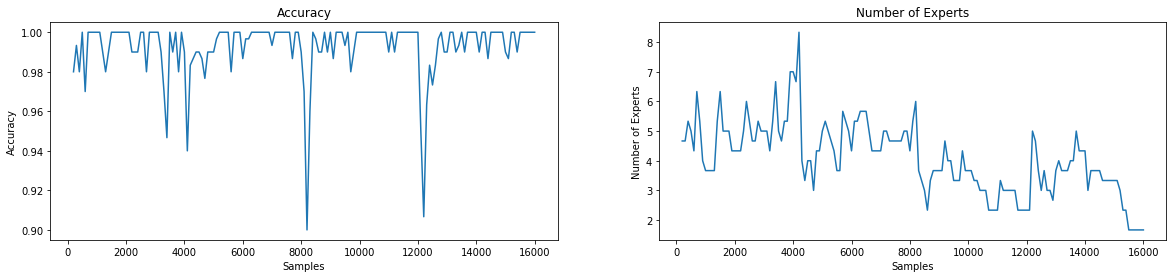







Mean Accuracy :  99.26415094339626 % 


Mean Number Of Experts :  4.0880503144654075






One Pass Time :  9.051701651679144 m






In [32]:
Ex = DWM(Data=Features, Target=Labels, Beta=0.5, Threshold = 0.01, Period= 1, Interval=100, TestSamples= 100, AccType="BeforeTrain", BaseType="Rand")

Ex.Run_Mul(3)

The expert 1 was created.
The expert 2 was created.
The expert 3 was created.
100
The expert 4 was created.
200
300
400
500
The expert 5 was created.
600
The expert 5 was removed with weight :  0.0078125
4  Remaining experts.
700
800
900
1000
1100
1200
The expert 6 was created.
1300
1400
1500
1600
1700
1800
1900
2000
2100
The expert 7 was created.
2200
The expert 7 was removed with weight :  0.0078125
5  Remaining experts.
The expert 8 was created.
2300
2400
2500
2600
The expert 9 was created.
2700
The expert 9 was removed with weight :  0.0078125
6  Remaining experts.
2800
2900
3000
3100
3200
The expert 6 was removed with weight :  0.0078125
5  Remaining experts.
The expert 10 was created.
3300
3400
3500
The expert 11 was created.
3600
3700
The expert 11 was removed with weight :  0.0078125
6  Remaining experts.
3800
3900
The expert 12 was created.
4000
The expert 13 was created.
The expert 14 was created.
4100
The expert 8 was removed with weight :  0.0078125
8  Remaining experts.
42

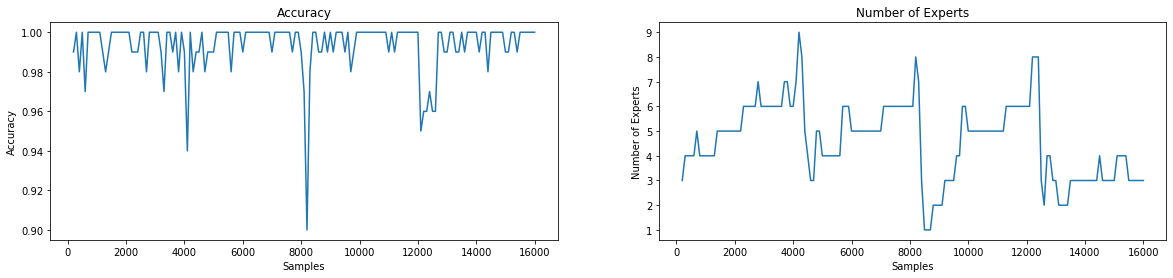







Mean Accuracy :  99.34591194968552 % 


Mean Number Of Experts :  4.616352201257862






One Pass Time :  11.535197349389394 m




The expert 1 was created.
The expert 2 was created.
The expert 3 was created.
100
The expert 4 was created.
200
300
400
The expert 3 was removed with weight :  0.0078125
3  Remaining experts.
The expert 2 was removed with weight :  0.0078125
2  Remaining experts.
The expert 4 was removed with weight :  0.0078125
1  Remaining experts.
500
The expert 5 was created.
600
The expert 5 was removed with weight :  0.0078125
1  Remaining experts.
700
800
900
1000
1100
1200
The expert 6 was created.
1300
1400
1500
The expert 6 was removed with weight :  0.0078125
1  Remaining experts.
1600
1700
1800
1900
2000
2100
The expert 7 was created.
2200
The expert 7 was removed with weight :  0.0078125
1  Remaining experts.
The expert 8 was created.
2300
The expert 8 was removed with weight :  0.0078125
1  Remaining experts.
2400
2500
2600
The expert 9 was created.
270

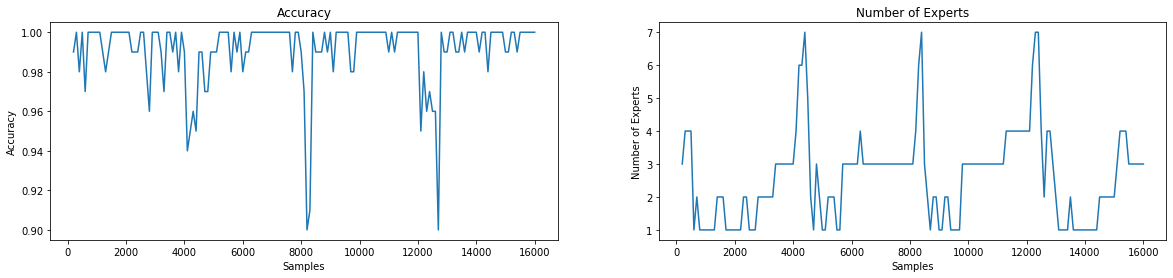







Mean Accuracy :  99.08805031446543 % 


Mean Number Of Experts :  2.610062893081761






One Pass Time :  5.703436370690664 m




The expert 1 was created.
The expert 2 was created.
The expert 3 was created.
The expert 4 was created.
The expert 5 was created.
100
200
300
The expert 6 was created.
400
The expert 2 was removed with weight :  0.0078125
5  Remaining experts.
500
The expert 1 was removed with weight :  0.0078125
4  Remaining experts.
The expert 6 was removed with weight :  0.0078125
3  Remaining experts.
The expert 7 was created.
600
The expert 3 was removed with weight :  0.0078125
3  Remaining experts.
The expert 7 was removed with weight :  0.0078125
2  Remaining experts.
700
800
900
1000
1100
1200
The expert 8 was created.
1300
1400
1500
1600
1700
1800
1900
2000
2100
The expert 9 was created.
2200
The expert 9 was removed with weight :  0.0078125
3  Remaining experts.
The expert 10 was created.
2300
2400
2500
2600
The expert 11 was created.
2700
2800
2900
3000
31

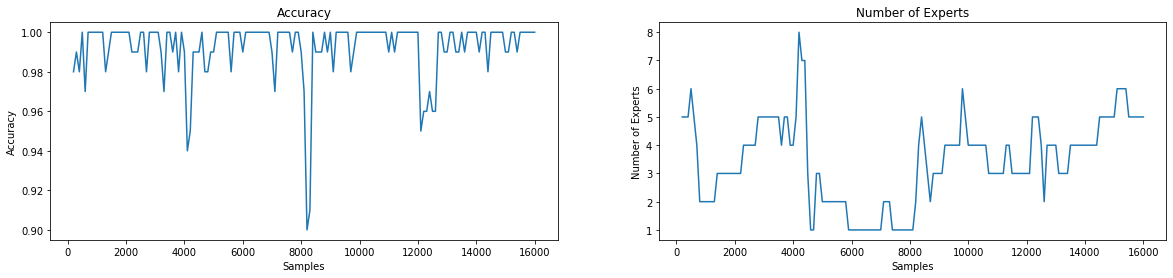







Mean Accuracy :  99.23899371069182 % 


Mean Number Of Experts :  3.4465408805031448






One Pass Time :  7.778262555599213 m






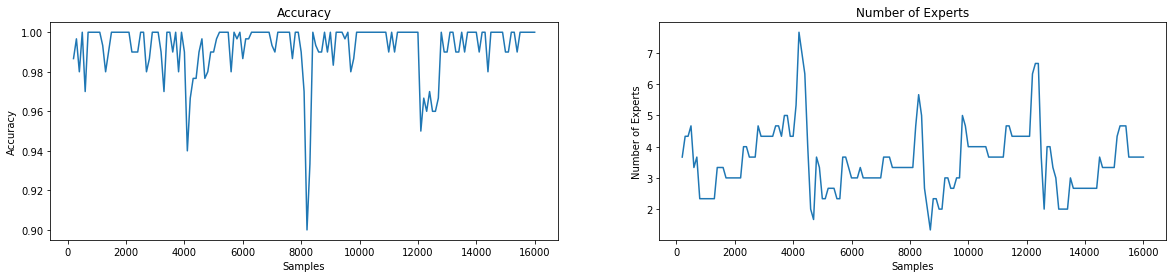







Mean Accuracy :  99.22431865828094 % 


Mean Number Of Experts :  3.5576519916142555






One Pass Time :  8.344344908661313 m






In [33]:
Ex = DWM(Data=Features, Target=Labels, Beta=0.5, Threshold = 0.01, Period= 2, Interval=100, TestSamples= 100, AccType="BeforeTrain", BaseType="Rand")

Ex.Run_Mul(3)

The expert 1 was created.
100
200
300
400
500
600
700
800
900
1000
1100
1200
The expert 2 was created.
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
The expert 3 was created.
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
The expert 4 was created.
3300
3400
The expert 4 was removed with weight :  0.0078125
3  Remaining experts.
3500
3600
3700
3800
3900
The expert 5 was created.
4000
The expert 6 was created.
4100
4200
4300
The expert 7 was created.
4400
The expert 5 was removed with weight :  0.0078125
5  Remaining experts.
The expert 2 was removed with weight :  0.0078125
4  Remaining experts.
4500
4600
The expert 8 was created.
4700
The expert 7 was removed with weight :  0.0078125
4  Remaining experts.
The expert 1 was removed with weight :  0.0078125
3  Remaining experts.
The expert 3 was removed with weight :  0.0078125
2  Remaining experts.
4800
4900
5000
5100
5200
5300
5400
5500
The expert 9 was created.
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
690

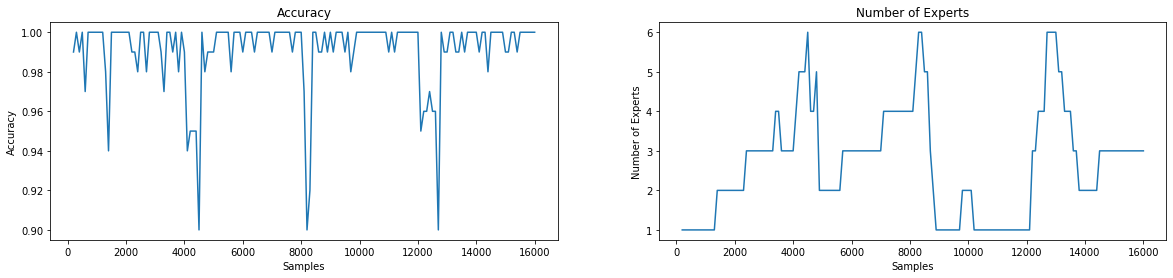







Mean Accuracy :  99.0880503144654 % 


Mean Number Of Experts :  2.6792452830188678






One Pass Time :  6.710269629955292 m




The expert 1 was created.
100
200
300
400
500
600
700
800
900
1000
1100
1200
The expert 2 was created.
1300
1400
1500
1600
1700
The expert 2 was removed with weight :  0.0078125
1  Remaining experts.
1800
1900
2000
2100
2200
The expert 3 was created.
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
The expert 4 was created.
3300
3400
3500
3600
3700
3800
3900
The expert 5 was created.
4000
The expert 6 was created.
4100
4200
4300
The expert 7 was created.
4400
The expert 6 was removed with weight :  0.0078125
5  Remaining experts.
4500
The expert 1 was removed with weight :  0.0078125
4  Remaining experts.
The expert 3 was removed with weight :  0.0078125
3  Remaining experts.
4600
The expert 8 was created.
4700
The expert 7 was removed with weight :  0.0078125
3  Remaining experts.
4800
4900
The expert 4 was removed with weight :  0.0078125
2  Remain

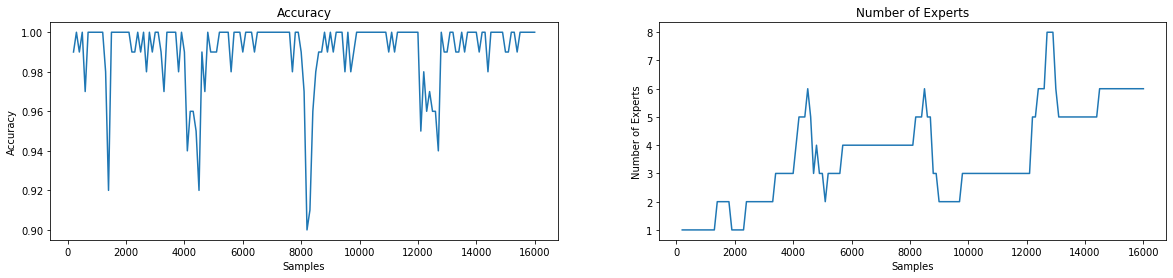







Mean Accuracy :  99.0754716981132 % 


Mean Number Of Experts :  3.6289308176100628






One Pass Time :  9.71862058242162 m




The expert 1 was created.
100
200
300
400
500
600
700
800
900
1000
1100
1200
The expert 2 was created.
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
The expert 3 was created.
2300
2400
2500
The expert 3 was removed with weight :  0.0078125
2  Remaining experts.
2600
2700
2800
2900
3000
3100
3200
The expert 4 was created.
3300
3400
3500
3600
3700
3800
3900
The expert 5 was created.
4000
The expert 6 was created.
4100
4200
4300
The expert 7 was created.
4400
The expert 2 was removed with weight :  0.0078125
5  Remaining experts.
The expert 6 was removed with weight :  0.0078125
4  Remaining experts.
4500
The expert 1 was removed with weight :  0.0078125
3  Remaining experts.
4600
The expert 8 was created.
4700
4800
4900
The expert 4 was removed with weight :  0.0078125
3  Remaining experts.
5000
5100
5200
5300
5400
5500
The expert 9 was created.
5600

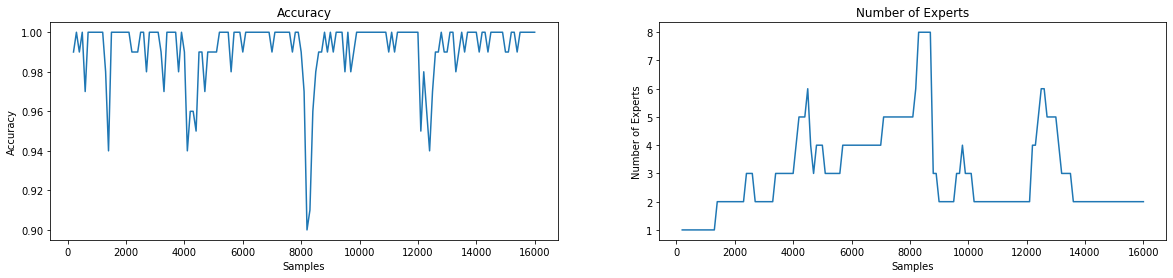







Mean Accuracy :  99.1761006289308 % 


Mean Number Of Experts :  3.0377358490566038






One Pass Time :  8.008411093552906 m






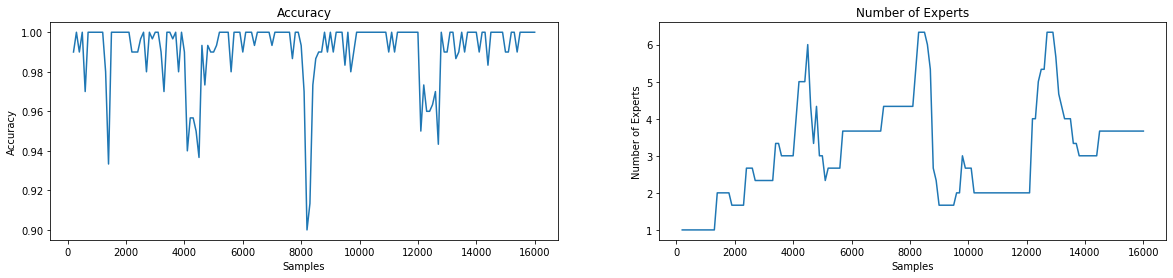







Mean Accuracy :  99.11320754716981 % 


Mean Number Of Experts :  3.1153039832285137






One Pass Time :  8.151208963659075 m






In [34]:
Ex = DWM(Data=Features, Target=Labels, Beta=0.5, Threshold = 0.01, Period= 4, Interval=100, TestSamples= 100, AccType="BeforeTrain", BaseType="Rand")

Ex.Run_Mul(3)

## Generated Concept

## Generate Data

In [0]:
Size = 6000

Third = int(Size/3)

Features = np.random.rand(Size,2)*10

Labels = np.ndarray([Size, 1])

Labels[:Third, 0] = Features[:Third, 0]*Features[:Third, 1] > 50

Labels[Third:2*Third, 0] = Features[Third:2*Third, 0]*Features[Third:2*Third, 1] < 50

Labels[2*Third:3*Third, 0] = Features[2*Third:3*Third, 0]*Features[2*Third:3*Third, 1] > 50

Labels = Labels[:,0]

### One Learner

#### NB

In [36]:
OneLearner(Features, Labels, "NB", 80, 20)



Accuracy :  64.86486486486487 %




#### LG

In [37]:
OneLearner(Features, Labels, "LG", 80, 20)



Accuracy :  65.0 %




### NB Base Learners

The expert 1 was created.
The expert 2 was created.
The expert 3 was created.
The expert 4 was created.
100
The expert 5 was created.
The expert 6 was created.
The expert 7 was created.
200
The expert 8 was created.
The expert 9 was created.
The expert 10 was created.
The expert 11 was created.
300
The expert 12 was created.
The expert 13 was created.
The expert 14 was created.
400
The expert 15 was created.
The expert 16 was created.
500
The expert 17 was created.
The expert 18 was created.
600
The expert 19 was created.
The expert 20 was created.
700
The expert 21 was created.
The expert 16 was removed with weight :  0.0078125
20  Remaining experts.
The expert 18 was removed with weight :  0.0078125
19  Remaining experts.
The expert 22 was created.
The expert 23 was created.
The expert 24 was created.
The expert 25 was created.
The expert 15 was removed with weight :  0.0078125
22  Remaining experts.
The expert 26 was created.
800
The expert 7 was removed with weight :  0.0078125
22 

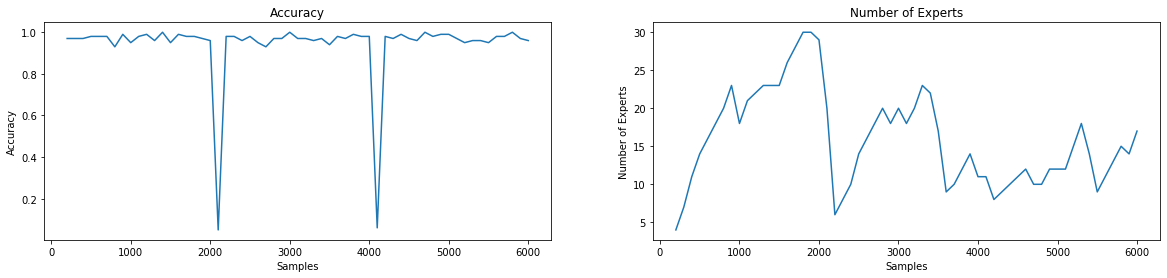







Mean Accuracy :  94.11864406779658 % 


Mean Number Of Experts :  15.847457627118644






One Pass Time :  1.2849303603172302 m






In [38]:
Ex = DWM(Data=Features, Target=Labels, Beta=0.5, Threshold = 0.01, Period= 1, Interval=100, TestSamples= 100, AccType="BeforeTrain", BaseType="NB")

Ex.Run()

The expert 1 was created.
The expert 2 was created.
The expert 3 was created.
100
The expert 4 was created.
The expert 5 was created.
200
The expert 6 was created.
The expert 7 was created.
300
The expert 8 was created.
The expert 9 was created.
400
The expert 10 was created.
The expert 11 was created.
500
600
700
The expert 12 was created.
The expert 13 was created.
800
900
The expert 14 was created.
The expert 15 was created.
1000
The expert 16 was created.
1100
The expert 17 was created.
1200
The expert 18 was created.
The expert 13 was removed with weight :  0.0078125
17  Remaining experts.
The expert 19 was created.
1300
1400
The expert 20 was created.
The expert 21 was created.
1500
1600
The expert 22 was created.
1700
The expert 23 was created.
1800
The expert 12 was removed with weight :  0.0078125
21  Remaining experts.
The expert 17 was removed with weight :  0.0078125
20  Remaining experts.
1900
The expert 24 was created.
The expert 4 was removed with weight :  0.0078125
20 

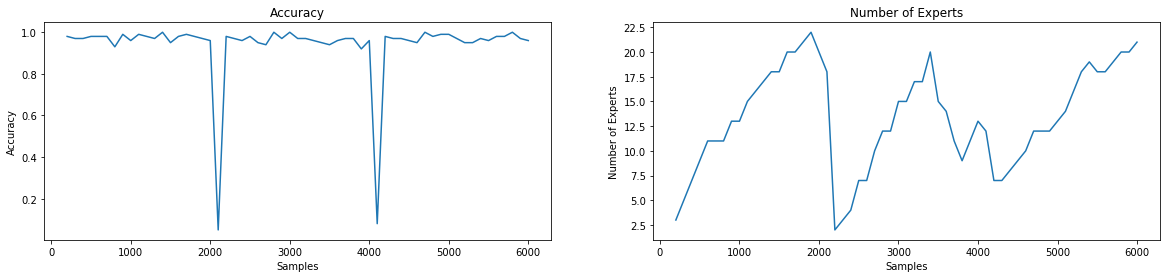







Mean Accuracy :  93.96610169491524 % 


Mean Number Of Experts :  13.338983050847459






One Pass Time :  1.1889821966489156 m






In [39]:
Ex = DWM(Data=Features, Target=Labels, Beta=0.5, Threshold = 0.01, Period= 2, Interval=100, TestSamples= 100, AccType="BeforeTrain", BaseType="NB")

Ex.Run()

The expert 1 was created.
100
The expert 2 was created.
200
300
The expert 3 was created.
400
The expert 4 was created.
500
600
700
The expert 5 was created.
800
900
1000
The expert 6 was created.
1100
The expert 7 was created.
The expert 8 was created.
1200
1300
1400
The expert 9 was created.
1500
1600
1700
The expert 10 was created.
1800
The expert 8 was removed with weight :  0.0078125
9  Remaining experts.
1900
The expert 11 was created.
2000
The expert 12 was created.
The expert 13 was created.
The expert 7 was removed with weight :  0.0078125
11  Remaining experts.
The expert 5 was removed with weight :  0.0078125
10  Remaining experts.
The expert 6 was removed with weight :  0.0078125
9  Remaining experts.
The expert 4 was removed with weight :  0.0078125
8  Remaining experts.
The expert 2 was removed with weight :  0.0078125
7  Remaining experts.
The expert 3 was removed with weight :  0.0078125
6  Remaining experts.
The expert 1 was removed with weight :  0.0078125
5  Remainin

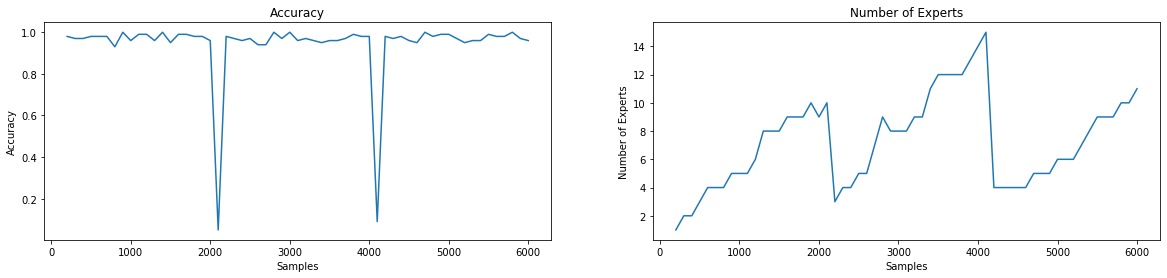







Mean Accuracy :  94.25423728813558 % 


Mean Number Of Experts :  7.237288135593221






One Pass Time :  0.688766360282898 m






In [40]:
Ex = DWM(Data=Features, Target=Labels, Beta=0.5, Threshold = 0.01, Period= 4, Interval=100, TestSamples= 100, AccType="BeforeTrain", BaseType="NB")

Ex.Run()